In [1]:
import os
import operator

import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from clickhouse_driver import Client

client = Client('localhost', database="thesisproxyconnectionreusedb")

In [2]:
%%time 

exp_data_sql = """
SELECT
	ex.*
FROM
	experiment ex
"""
exp_df = client.query_dataframe(exp_data_sql)

print(len(exp_df.exp_id.unique().tolist()))
print("\n".join(exp_df.exp_id.unique().tolist()))
print()

exp_df.loc[exp_df["exp_id"].str.contains("noconnreuse"), "reuse_connections"] = False

pprint(exp_df.columns)
print()
exp_df

8
thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_connection_reuse_8clien

exp_id  \
0    thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
2     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
4  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
5  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
6   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
7   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

  attacker_rate  server_connections  max_keep_alive_requests  num_clients  \
0         0mbps                 256                        0            8   
1         0mbps                 256                        0            8   
2         0mbps                 256                        0            8   
3         0mbps                 256                        0            8   
4       100mbps                 256                        0            8   
5       100mbps                 256                        0            8   
6       100mbps                 256                        0            8   
7       100mbps                 256                        0            8   

   num_trials  origin_server_duration  attacker_duration  receiver_duration  \
0           5                     140                 30                140   
1           5                     140                 30                140   
2           5                     140                 30                140   
3           5                     140                 30                140   
4           5                     140                 30                140   
5           5                     140                 30                140   
6           5                     140                 30                140   
7           5                     140                 30                140   

   proxy_duration  ...                             topology_name  \
0             140  ...  thesis_cloud_proxy_and_internet_attacker   
1             140  ...  thesis_cloud_proxy_and_internet_attacker   
2             140  ...  thesis_cloud_proxy_and_internet_attacker   
3             140  ...  thesis_cloud_proxy_and_internet_attacker   
4             140  ...  thesis_cloud_proxy_and_internet_attacker   
5             140  ...  thesis_cloud_proxy_and_internet_attacker   
6             140  ...  thesis_cloud_proxy_and_internet_attacker   
7             140  ...  thesis_cloud_proxy_and_internet_attacker   

   num_proxy_connections request_timeout  max_retries keep_alive_duration  \
0                     50               5            2                   5   
1                     50               5            2                   5   
2                     50               5            2                   5   
3                     50               5            2                   5   
4                     50               5            2                   5   
5                     50               5            2                   5   
6                     50               5            2                   5   
7                 

In [3]:
%%time 

fetch_metadata_sql = """
SELECT
	n.node_name,
	dn.dnid,
	dn.node_id,
  dn.exp_id
FROM 
	deployed_node dn
	JOIN node n ON n.node_id = dn.node_id
"""

metadata_df = client.query_dataframe(fetch_metadata_sql)

dnid_map_node_name = dict()
dnid_map_exp_id = dict()
node_id_map_node_name = dict()

for record in metadata_df.to_dict(orient="records"):
  dnid = record["dnid"]
  node_id = record["node_id"]
  node_name = record["node_name"]
  exp_id = record["exp_id"]
  
  assert dnid not in dnid_map_node_name
  dnid_map_node_name[dnid] = node_name
  dnid_map_exp_id[dnid] = exp_id
  
  if node_id in node_id_map_node_name:
    assert node_id_map_node_name[node_id] == node_name
  else:
    node_id_map_node_name[node_id] = node_name
  
client_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("client"))
attacker_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("attacker"))

client_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("client"))

print(f"{client_dnids=}")
print(f"{attacker_dnids=}")
print(f"{client_node_ids=}")

client_dnids={2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 33, 38, 39, 40, 41, 42, 43, 44, 45, 50, 51, 52, 53, 54, 55, 56, 57, 62, 63, 64, 65, 66, 67, 68, 69, 74, 75, 76, 77, 78, 79, 80, 81, 86, 87, 88, 89, 90, 91, 92, 93}
attacker_dnids={1, 37, 73, 13, 49, 85, 25, 61}
client_node_ids={2, 3, 4, 5, 6, 7, 8, 9}
CPU times: user 19.9 ms, sys: 0 ns, total: 19.9 ms
Wall time: 46.2 ms


In [4]:
client_messages_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
), 

client_recvs AS (
  SELECT
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.trial AS trial,
  client_sends.observer_id AS observer_id,
  client_sends.message_marker AS message_marker,
  groupArray(client_recvs.response_code)[1] AS response_code,
  MIN(client_sends.observe_timestamp) AS send_time_sec,
  MIN(client_recvs.observe_timestamp) AS recv_time_sec,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  MAX(client_sends.observe_timestamp) AS last_send_time_sec,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec,
  MAX(client_recvs.observe_timestamp) AS last_recv_time_sec,
  1e3 * (MIN(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS rtt_ms_first_transmission,
  1e3 * (MIN(client_recvs.observe_timestamp) - MAX(client_sends.observe_timestamp)) AS rtt_ms_last_transmission,
  COUNT(client_sends.observe_timestamp) AS num_send_observations,
  COUNT(client_recvs.observe_timestamp) AS num_recv_observations,
  SUM(CASE WHEN client_sends.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM client_sends
  LEFT JOIN client_recvs USING (trial, observer_id, message_marker)
GROUP BY 
  exp_id, trial, observer_id, message_marker
ORDER BY
  exp_id, trial, observer_id, message_marker
"""

message_rtt_df = client.query_dataframe(client_messages_sql)
message_rtt_df.observer_id.replace(dnid_map_node_name, inplace=True)

message_rtt_df["successful_message"] = False
message_rtt_df.loc[(message_rtt_df["response_code"] == "content"), "successful_message"] = True

print(message_rtt_df["response_code"].unique())

message_rtt_df = message_rtt_df.merge(exp_df, on="exp_id", how="left")

# Due to left join, we need to eliminate lines that
# have negative RTT, so we NaN them.
message_rtt_df.loc[
  (message_rtt_df["rtt_ms_first_transmission"] < 0)
  | (message_rtt_df["rtt_ms_last_transmission"] < 0)
  ,
  ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]
] = np.nan

message_rtt_df

['content' '' 'bad_gateway']


exp_id  \
0        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                                 ...   
512797  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
512798  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
512799  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
512800  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
512801  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

        trial observer_id  message_marker response_code  send_time_sec  \
0           1     client1               1       content       0.000000   
1           1     client1               2       content       0.342471   
2           1     client1               3       content       0.440279   
3           1     client1               4       content       0.533037   
4           1     client1               5       content       0.630923   
...       ...         ...             ...           ...            ...   
512797      5     client8          711951       content     125.473589   
512798      5     client8          711952       content     125.527217   
512799      5     client8          711953       content     125.580866   
512800      5     client8          711954       content     125.634524   
512801      5     client8          711955                   125.688146   

        recv_time_sec  first_send_time_sec  last_send_time_sec  \
0            0.326965             0.000000            0.000000   
1            0.437995             0.342471            0.342471   
2            0.531198             0.440279            0.440279   
3            0.628770             0.533037            0.533037   
4            0.716940             0.630923            0.630923   
...               ...                  ...                 ...   
512797     125.526408           125.473589          125.473589   
512798     125.580026           125.527217          125.527217   
512799     125.633697           125.580866          125.580866   
512800     125.687322           125.634524          125.634524   
512801       0.000000           125.688146          125.688146   

        first_recv_time_sec  ...                             topology_name  \
0                  0.326965  ...  thesis_cloud_proxy_and_internet_attacker   
1                  0.437995  ...  thesis_cloud_proxy_and_internet_attacker   
2                  0.531198  ...  thesis_cloud_proxy_and_internet_attacker   
3                  0.628770  ...  thesis_cloud_proxy_and_internet_attacker   
4                  0.716940  ...  th

In [5]:
%%time

client_sends_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
)

SELECT * FROM client_sends
ORDER BY exp_id, trial, observer_id, message_marker
"""

client_sends_df = client.query_dataframe(client_sends_sql)
client_sends_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_sends_df

CPU times: user 1.08 s, sys: 208 ms, total: 1.28 s
Wall time: 1.73 s


exp_id  \
0        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                                 ...   
513828  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
513829  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
513830  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
513831  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
513832  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

        observe_timestamp  trial observer_id  message_marker  \
0                0.000000      1     client1               1   
1                0.342471      1     client1               2   
2                0.440279      1     client1               3   
3                0.533037      1     client1               4   
4                0.630923      1     client1               5   
...                   ...    ...         ...             ...   
513828         125.473589      5     client8          711951   
513829         125.527217      5     client8          711952   
513830         125.580866      5     client8          711953   
513831         125.634524      5     client8          711954   
513832         125.688146      5     client8          711955   

        coap_retransmitted  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False  
...                    ...  
513828               False  
513829               False  
513830               False  
513831               False  
513832               False  

[513833 rows x 6 columns]

In [6]:
%%time

client_recvs_sql = f"""
WITH client_recvs AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT * FROM client_recvs
ORDER BY exp_id, trial, observer_id, message_marker
"""

client_recvs_df = client.query_dataframe(client_recvs_sql)
client_recvs_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_recvs_df["successful_message"] = False
client_recvs_df.loc[(client_recvs_df["response_code"] == "content"), "successful_message"] = True

print(client_recvs_df["response_code"].unique())

client_recvs_df

['content' 'bad_gateway']
CPU times: user 1.28 s, sys: 202 ms, total: 1.49 s
Wall time: 1.94 s


exp_id  \
0        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                                 ...   
512487  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
512488  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
512489  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
512490  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
512491  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

        observe_timestamp  trial observer_id  message_marker response_code  \
0                0.326965      1     client1               1       content   
1                0.437995      1     client1               2       content   
2                0.531198      1     client1               3       content   
3                0.628770      1     client1               4       content   
4                0.716940      1     client1               5       content   
...                   ...    ...         ...             ...           ...   
512487         125.472758      5     client8          711950       content   
512488         125.526408      5     client8          711951       content   
512489         125.580026      5     client8          711952       content   
512490         125.633697      5     client8          711953       content   
512491         125.687322      5     client8          711954       content   

        successful_message  
0                     True  
1                     True  
2                     True  
3                     True  
4                     True  
...                    ...  
512487                True  
512488                True  
512489                True  
512490                True  
512491                True  

[512492 rows x 7 columns]

In [119]:
%%time

metric_usage_sql = f"""
SELECT
	dn.exp_id,
	nm.trial,
	nm.observer_id,
	nm.metric_type,
	AVG(nm.metric_value) AS avg_value,
	MIN(nm.metric_value) AS min_value,
	MAX(nm.metric_value) AS max_value
FROM
	node_metric nm
	JOIN deployed_node dn ON dn.dnid = nm.observer_id
GROUP BY
	dn.exp_id, nm.trial, nm.observer_id, nm.metric_type
ORDER BY
	dn.exp_id, nm.trial, nm.metric_type, nm.observer_id
"""

metric_df = client.query_dataframe(metric_usage_sql)

metric_df.observer_id.replace(dnid_map_node_name, inplace=True)

metric_df = metric_df.merge(exp_df, on="exp_id", how="left")

metric_df

CPU times: user 28.8 ms, sys: 3.02 ms, total: 31.8 ms
Wall time: 132 ms


exp_id  \
0     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                               ...   
155  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
156  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
157  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
158  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
159  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial   observer_id         metric_type    avg_value  min_value  \
0        1  originserver     cpu_utilization     2.380000        0.4   
1        1         proxy     cpu_utilization     7.144286        0.5   
2        1  originserver  memory_utilization   267.950413      245.0   
3        1         proxy  memory_utilization   515.880795      264.0   
4        2  originserver     cpu_utilization     2.401429        0.4   
..     ...           ...                 ...          ...        ...   
155      4         proxy  memory_utilization  3856.508333      268.0   
156      5  originserver     cpu_utilization     5.586429        0.4   
157      5         proxy     cpu_utilization    16.064286        0.4   
158      5  originserver  memory_utilization   274.095868      251.0   
159      5         proxy  memory_utilization  3796.620000      268.0   

     max_value attacker_rate  server_connections  max_keep_alive_requests  \
0         10.8         0mbps                 256                        0   
1         22.1         0mbps                 256                        0   
2        271.0         0mbps                 256                        0   
3        537.0         0mbps                 256                        0   
4         10.0         0mbps                 256                        0   
..         ...           ...                 ...                      ...   
155     6450.0       100mbps                 256                        0   
156       23.4       100mbps                 256                        0   
157       91.9       100mbps                 256                        0   
158      301.0       100mbps                 256                        0   
159     6280.0       100mbps                 256                        0   

     ...                             topology_name  num_proxy_connections  \
0    ...  thesis_cloud_proxy_and_internet_attacker                     50   
1    ...  thesis_cloud_proxy_and_internet_attacker                     50   
2    ...  thesis_cloud_proxy_and_internet_attacker                     50   
3    ...  thesis_cloud_proxy_and_internet_a

In [78]:
%%time

client_rps_df = (
  message_rtt_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .aggregate(
    num_messages=("successful_message", "count"),
    num_successful_messages=("successful_message", "sum"),
    mean_rps=("successful_message", "sum"),
    max_num_retransmissions=("num_retransmissions", "max"),
    total_num_retransmissions=("num_retransmissions", "sum"),
    stddev_rtt_ms=("rtt_ms_first_transmission", "std"),
    min_rtt_ms=("rtt_ms_first_transmission", "min"),
    median_rtt_ms=("rtt_ms_first_transmission", "median"),
    mean_rtt_ms=("rtt_ms_first_transmission", "mean"),
    max_rtt_ms=("rtt_ms_first_transmission", "max"),
    rtt_ms_p0=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.00)),
    rtt_ms_p25=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.25)),
    rtt_ms_p50=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.50)),
    rtt_ms_p75=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.75)),
    rtt_ms_p90=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.90)),
    rtt_ms_p99=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.99)),
    rtt_ms_p100=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=1.00)),
    first_active_time=("first_send_time_sec", "min"),
    last_active_time=("last_recv_time_sec", "max"),
  )
  .reset_index()
)
assert client_rps_df["min_rtt_ms"].eq(client_rps_df["rtt_ms_p0"]).all()
assert client_rps_df["median_rtt_ms"].eq(client_rps_df["rtt_ms_p50"]).all()
assert client_rps_df["max_rtt_ms"].eq(client_rps_df["rtt_ms_p100"]).all()

client_rps_df["num_failed_messages"] = client_rps_df["num_messages"] - client_rps_df["num_successful_messages"]
client_rps_df["average_rps"] = client_rps_df["num_successful_messages"] / (client_rps_df["last_active_time"] - client_rps_df["first_active_time"])

client_rps_df = client_rps_df.merge(exp_df, on="exp_id")
bool_col_replacement = {
  "run_proxy_with_dtls": {True: "dtls", False: "coap"},
  "run_proxy_with_https": {True: "https", False: "http"},
  "reuse_connections": {True: "reuse-connections", False: "no-connection-reuse"},
  "run_attacker": {True: "attacker", False: "no-attacker"},
}
client_rps_df.replace(bool_col_replacement, inplace=True)

client_rps_df["mean_rps"] /= client_rps_df["client_duration"]

client_rps_df[["exp_id", "trial", "observer_id", "mean_rps"]]

client_rps_df

CPU times: user 2.86 s, sys: 7.83 ms, total: 2.87 s
Wall time: 2.86 s


exp_id  \
0     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                               ...   
315  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
316  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
317  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
318  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
319  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id  num_messages  num_successful_messages   mean_rps  \
0        1     client1          1529                     1528  12.733333   
1        1     client2          1534                     1533  12.775000   
2        1     client3          1535                     1534  12.783333   
3        1     client4          1535                     1534  12.783333   
4        1     client5          1536                     1535  12.791667   
..     ...         ...           ...                      ...        ...   
315      5     client4          1574                     1571  13.091667   
316      5     client5          1577                     1574  13.116667   
317      5     client6          1575                     1570  13.083333   
318      5     client7          1576                     1573  13.108333   
319      5     client8          1576                     1571  13.091667   

     max_num_retransmissions  total_num_retransmissions  stddev_rtt_ms  \
0                          0                          0       6.697733   
1                          0                          0       1.732298   
2                          0                          0       1.739335   
3                          0                          0       1.614220   
4                          0                          0       1.557777   
..                       ...                        ...            ...   
315                        2                          6     406.806386   
316                        2                          7     344.336472   
317                        2                          7     349.602936   
318                        2                          8     430.741619   
319                        2                          6     416.808612   

     min_rtt_ms  ...                             topology_name  \
0     74.420929  ...  thesis_cloud_proxy_and_internet_attacker   
1     74.179173  ...  thesis_cloud_proxy_and_internet_attacker   
2     74.351072  ...  thesis_cloud_proxy_and_internet_attacker   
3     74.256897  ...  thesis_cloud_proxy_and_internet_attacker   
4     74.

In [120]:
### At this point, we generate figures for the paper

plt.rcParams['figure.dpi']  = 300
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['font.size']        = '18'
plt.rcParams['lines.linewidth']  = 3
plt.rcParams['lines.markersize'] = 9

value_map_replacement = {
  "run_proxy_with_dtls": {
    "coap": "CoAP",
    False: "CoAP",
    "dtls": "CoAPS",
    True: "CoAPS",
  },
  "reuse_connections": {
    "reuse-connections": "Reuse",
    True: "Reuse",
    "no-connection-reuse": "No Reuse",
    False: "No Reuse",
  },
  "run_attacker": {
    "attacker": "With Attacker",
    True: "With Attacker",
    "no-attacker": "Without Attacker",
    False: "Without Attacker",
  },
}

client_rps_df.replace(value_map_replacement, inplace=True)
metric_df.replace(value_map_replacement, inplace=True)

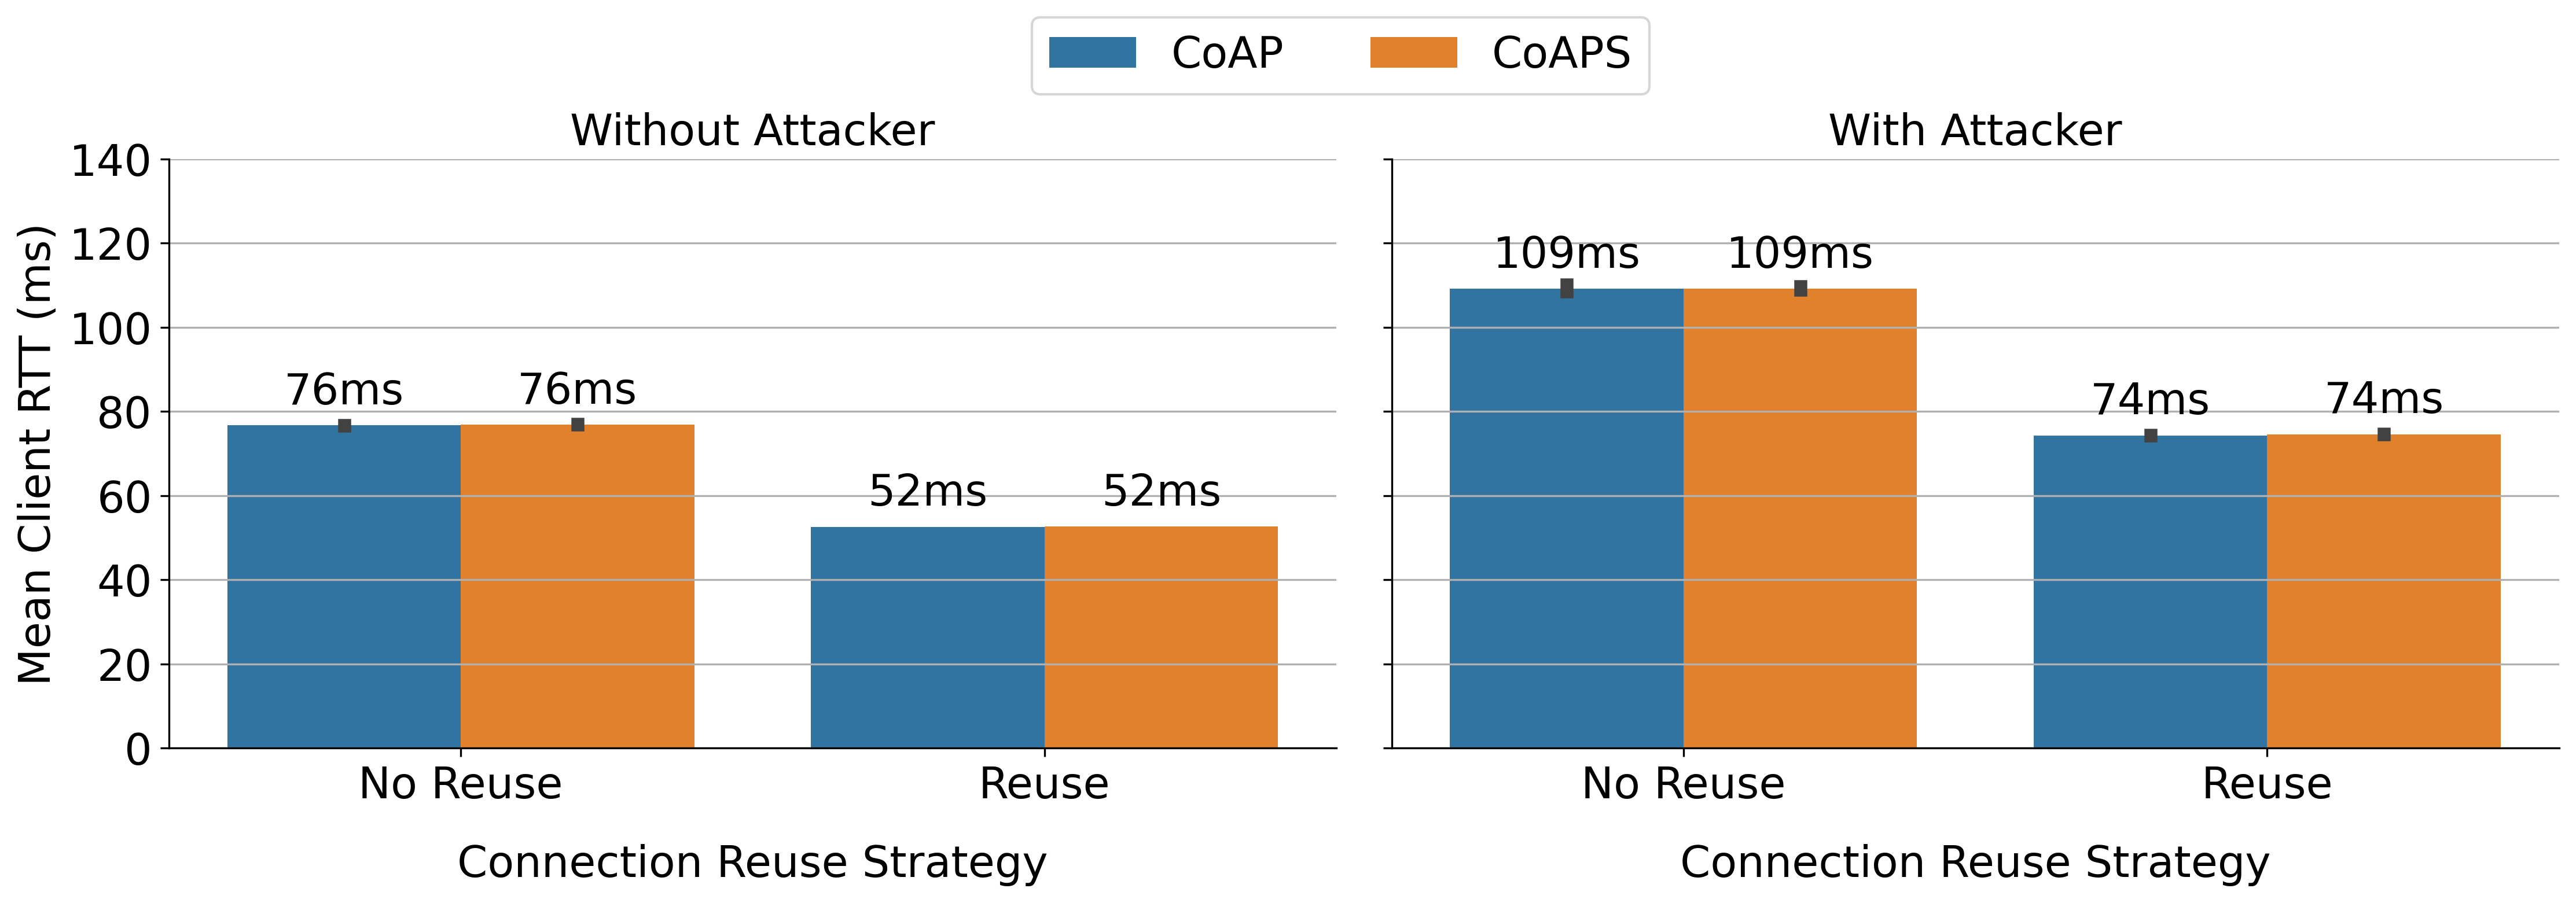

In [90]:
### Plot effect of RTT as a result of toggling attack and changing connection reuse strategy

df = client_rps_df

g = sns.catplot(
  data=df,
  kind="bar",
  x="reuse_connections",
  y="mean_rtt_ms",
  hue="run_proxy_with_dtls",
  col="run_attacker",
  aspect=1.25,
  facet_kws={
    "sharey": True,
    "sharex": True,
  },
)

g.set_titles(
  template="{col_name}",
)
# g.legend.set_title("Client Protocol")
g.set_xlabels("Connection Reuse Strategy", labelpad=15)
g.set_ylabels("Mean Client RTT (ms)")
g.set(
  yticks=np.arange(0,141,20),
)

axes = [
  g.axes[0,0],
  g.axes[0,1],
]
for ax in axes:
  ax.grid(True, axis="y")
  for container in ax.containers:
    ax.bar_label(container, fmt="%dms", padding=5)

sns.move_legend(
  g,
  "upper center",
  bbox_to_anchor=(0.52, 1.08),
  ncol=2,
  title=None,
  frameon=True,
)

plt.tight_layout()
plt.show()

In [43]:
(
  client_rps_df
  .groupby(by=["exp_id", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum"),
  )
  .reset_index()
)

exp_id  \
0     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
5     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
6     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
7     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
8     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
9     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
10     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
11     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
12     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
13     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
14     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
15     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
16     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
17     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
18     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
19     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
20  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
21  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
22  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
23  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140se

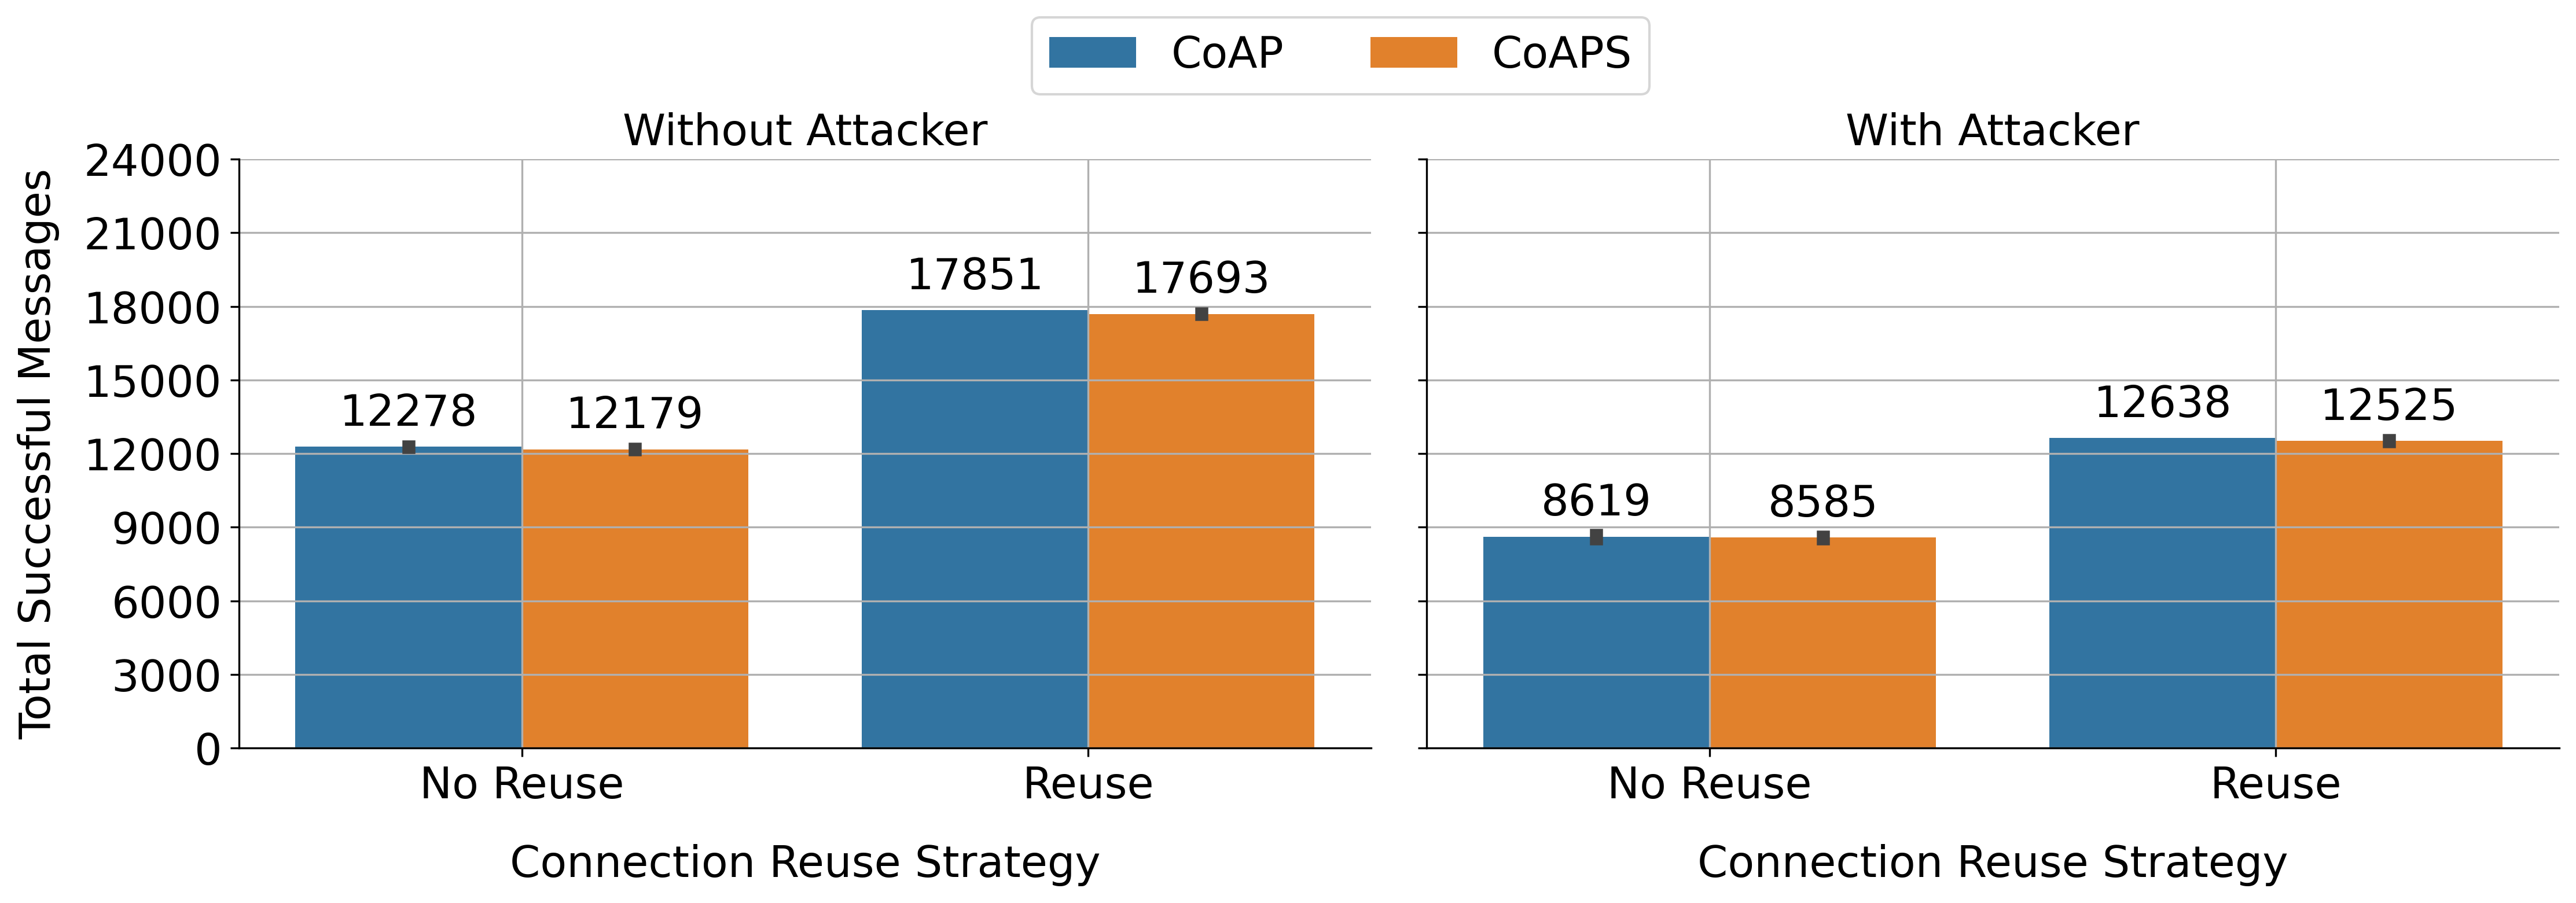

exp_id  \
0    thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
2     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
4  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
5  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
6   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
7   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

  run_proxy_with_dtls  num_clients      run_attacker reuse_connections  \
0                CoAP            8  Without Attacker          No Reuse   
1               CoAPS            8  Without Attacker          No Reuse   
2                CoAP            8  Without Attacker             Reuse   
3               CoAPS            8  Without Attacker             Reuse   
4                CoAP            8     With Attacker          No Reuse   
5               CoAPS            8     With Attacker          No Reuse   
6                CoAP            8     With Attacker             Reuse   
7               CoAPS            8     With Attacker             Reuse   

   mean_total_successful_messages  mean_successful_messages_per_client  
0                         12278.8                             1534.850  
1                         12179.2                             1522.400  
2                         17851.0                             2231.375  
3                         17693.4                             2211.675  
4                          8619.0                             1077.375  
5                          8585.2                             1073.150  
6                         12638.6                             1579.825  
7                         12525.4                             1565.675

In [102]:
## Plot total number of successful messages.

client_rps_df["active_time_sec"] = client_rps_df["last_active_time"] - client_rps_df["first_active_time"]

df = (
  client_rps_df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "reuse_connections", "run_attacker", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum"),
    mean_active_time_sec=("active_time_sec", "mean"),
  )
  .reset_index()
)
df["amortized_successful_rps"] = df["total_successful_messages"] / df["mean_active_time_sec"] / df["num_clients"]

g = sns.catplot(
  data=df,
  kind="bar",
  x="reuse_connections",
  y="total_successful_messages",
  hue="run_proxy_with_dtls",
  col="run_attacker",
  aspect=1.25,
)

# g.legend.set_title("Client Protocol")
g.set_xlabels("Connection Reuse Strategy", labelpad=15)
g.set_ylabels("Total Successful Messages", labelpad=10)
g.set_titles(
  template="{col_name}",
)
g.set(
  yticks=np.arange(0, 25_001, 3_000),
)

axes = [
  g.axes[0,0],
  g.axes[0,1],
]

for ax in axes:
  ax.grid(True, axis="both")
  for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=5)

sns.move_legend(
  g,
  "upper center",
  bbox_to_anchor=(0.52, 1.08),
  ncol=2,
  title=None,
  frameon=True,
)

plt.tight_layout()
plt.show()

_df = (
  df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "run_attacker", "reuse_connections"])
  .agg(
    mean_total_successful_messages=("total_successful_messages", "mean"),
  )
  .reset_index()
)
_df["mean_successful_messages_per_client"] = _df["mean_total_successful_messages"] / _df["num_clients"]
_df

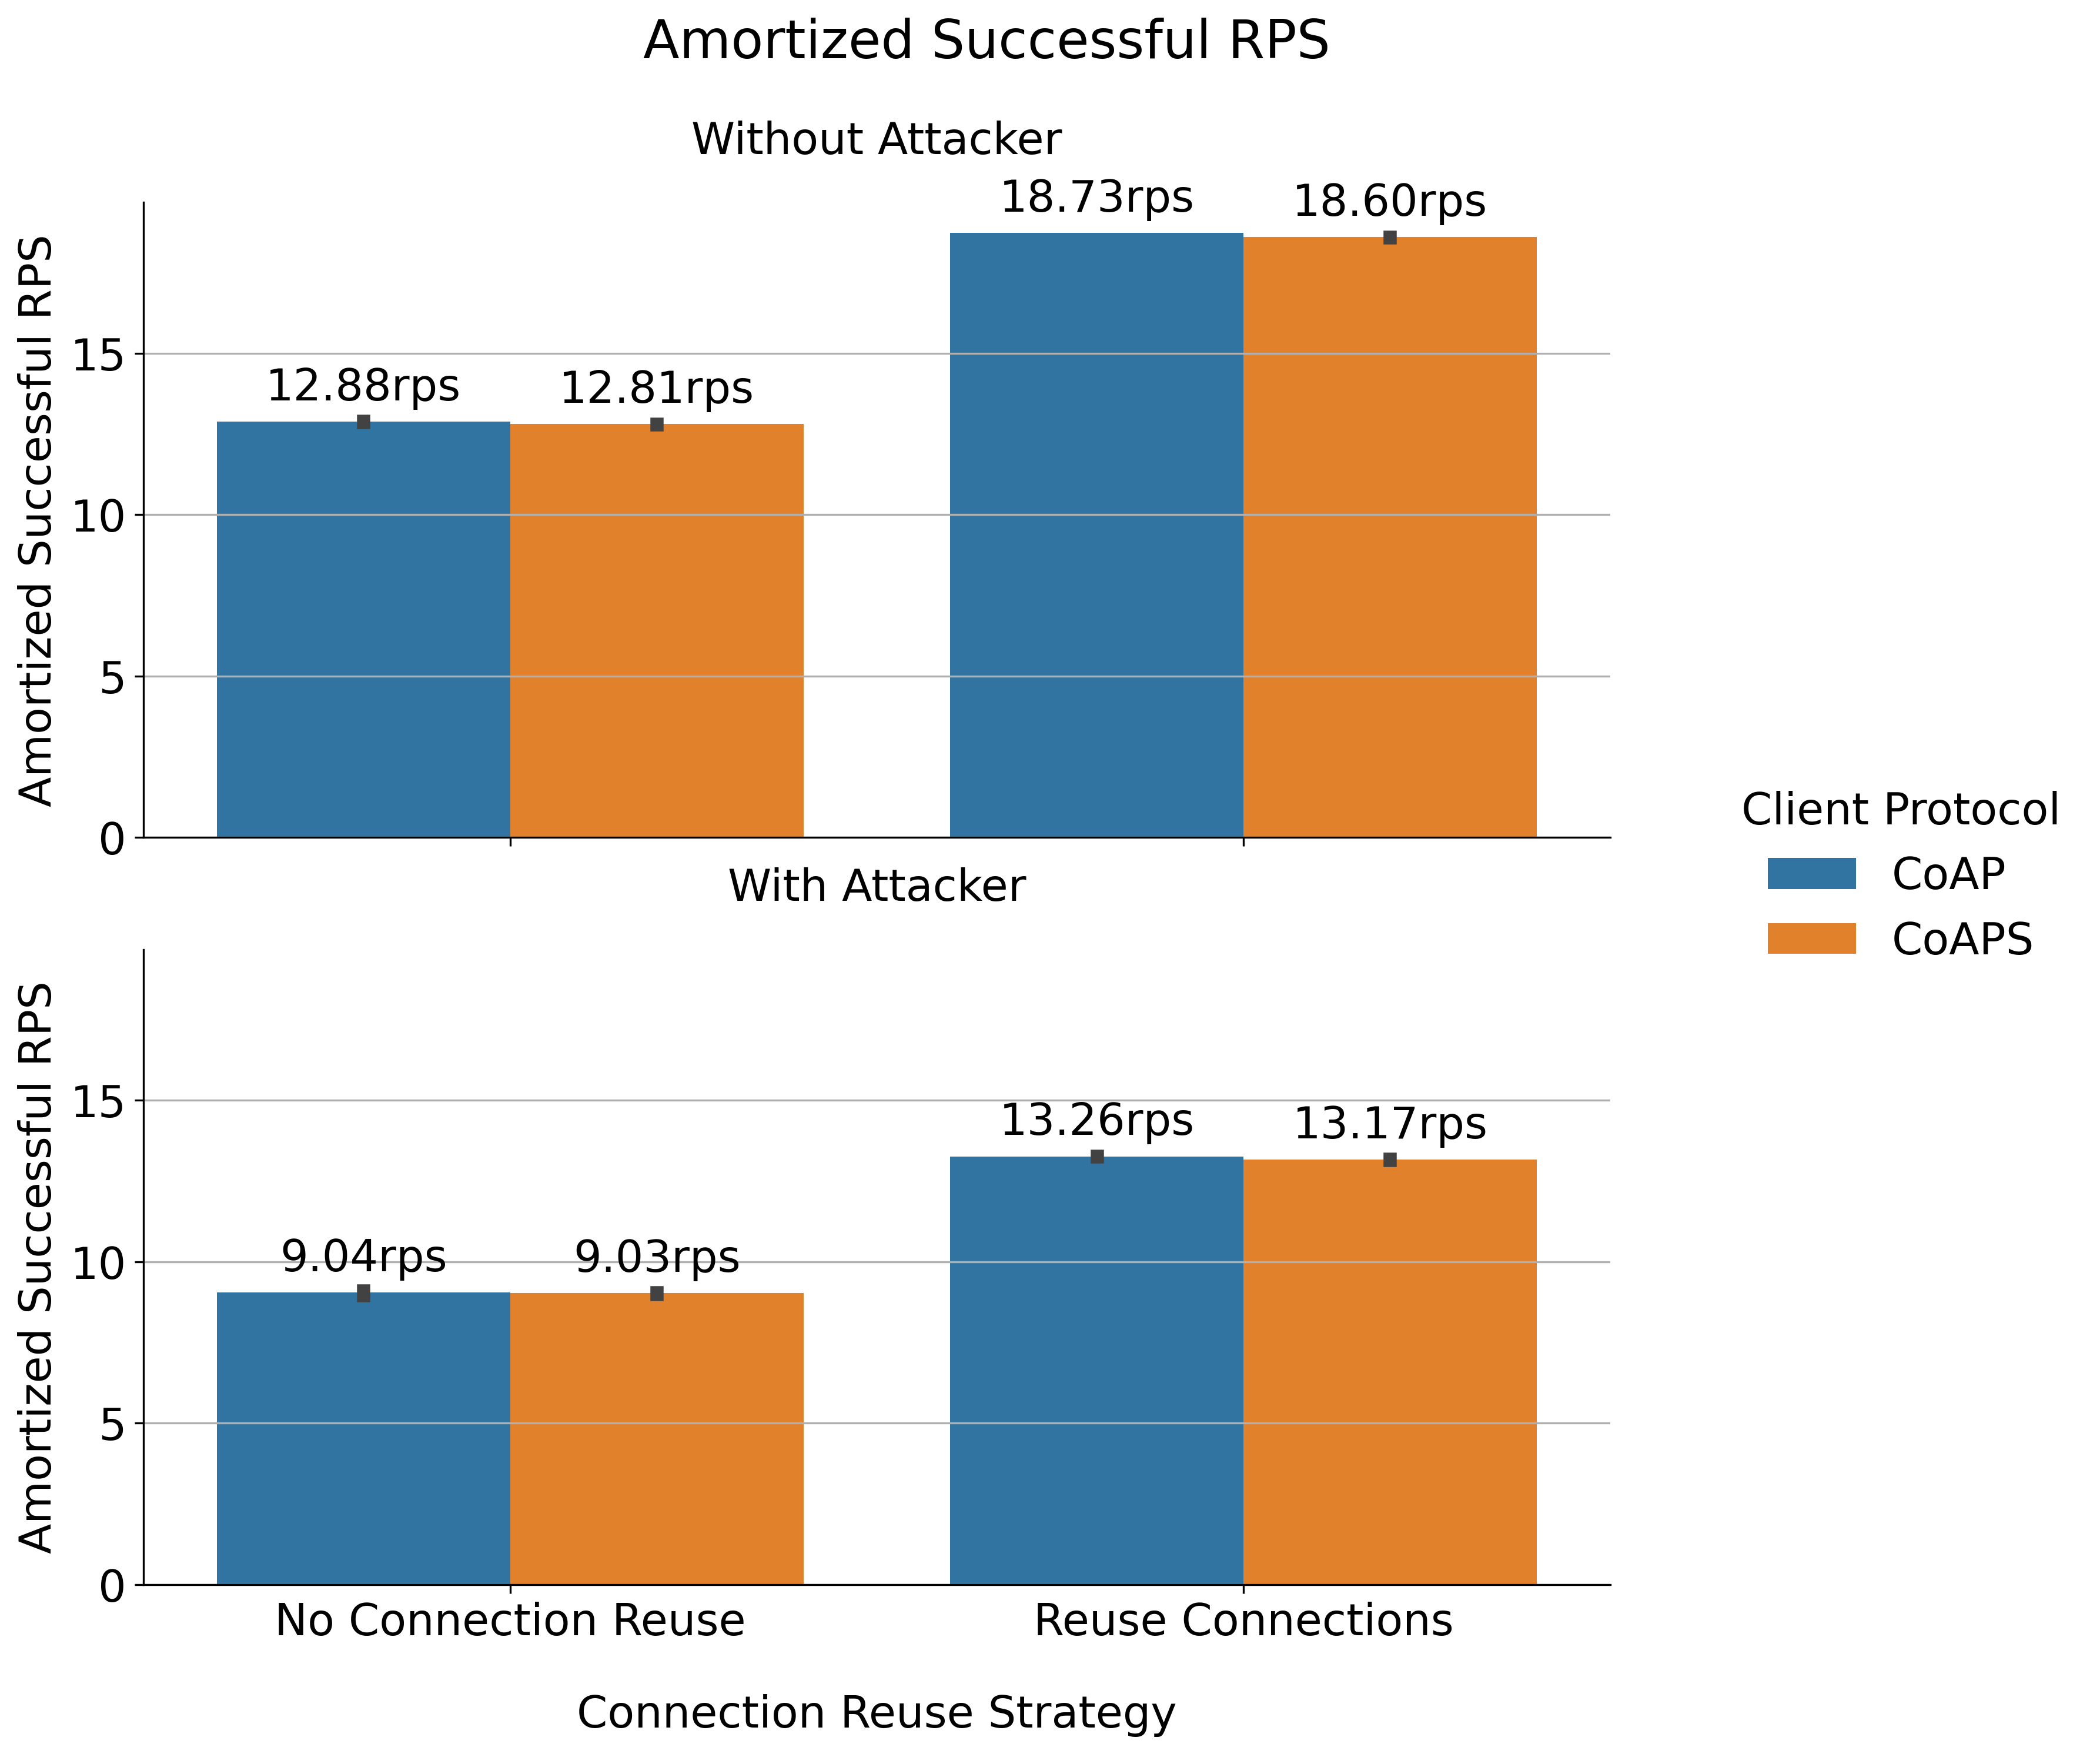

exp_id  \
0    thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
2     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
4  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
5  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
6   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
7   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

  run_proxy_with_dtls  num_clients    reuse_connections      run_attacker  \
0                CoAP            8  No Connection Reuse  Without Attacker   
1               CoAPS            8  No Connection Reuse  Without Attacker   
2                CoAP            8    Reuse Connections  Without Attacker   
3               CoAPS            8    Reuse Connections  Without Attacker   
4                CoAP            8  No Connection Reuse     With Attacker   
5               CoAPS            8  No Connection Reuse     With Attacker   
6                CoAP            8    Reuse Connections     With Attacker   
7               CoAPS            8    Reuse Connections     With Attacker   

   mean_amortized_successful_rps  mean_amortized_rps_messages_per_client  
0                      12.883528                                1.610441  
1                      12.805899                                1.600737  
2                      18.729825                                2.341228  
3                      18.600421                                2.325053  
4                       9.042825                                1.130353  
5                       9.026330                                1.128291  
6                      13.260224                                1.657528  
7                      13.166996                                1.645875

In [45]:
g = sns.catplot(
  data=df,
  kind="bar",
  x="reuse_connections",
  y="amortized_successful_rps",
  hue="run_proxy_with_dtls",
  row="run_attacker",
  aspect=2,
)

# g.set_xlabels("Number of Clients")
# g.set_ylabels("Amortized Successful RPS")
# g.legend.set_title("Client Protocol")

g.legend.set_title("Client Protocol")
g.set_xlabels("Connection Reuse Strategy", labelpad=20)
g.set_ylabels("Amortized Successful RPS")
g.set_titles(
  template="{row_name}",
  pad=20,
)
g.set(
  # yticks=np.arange(0,75_001,10_000),
)

axes = [
  g.axes[0,0],
  g.axes[1,0],
]

for ax in axes:
  ax.grid(True, axis="y")
  for container in ax.containers:
    ax.bar_label(container, fmt="%1.2frps", padding=5)
  ax.set_xticklabels(labels=["No Connection Reuse", "Reuse Connections"])

g.fig.subplots_adjust(top=0.875)
g.fig.suptitle("Amortized Successful RPS")

plt.show()

_df = (
  df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "reuse_connections", "run_attacker"])
  .agg(
    mean_amortized_successful_rps=("amortized_successful_rps", "mean"),
  )
  .reset_index()
)
_df["mean_amortized_rps_messages_per_client"] = _df["mean_amortized_successful_rps"] / _df["num_clients"]
_df

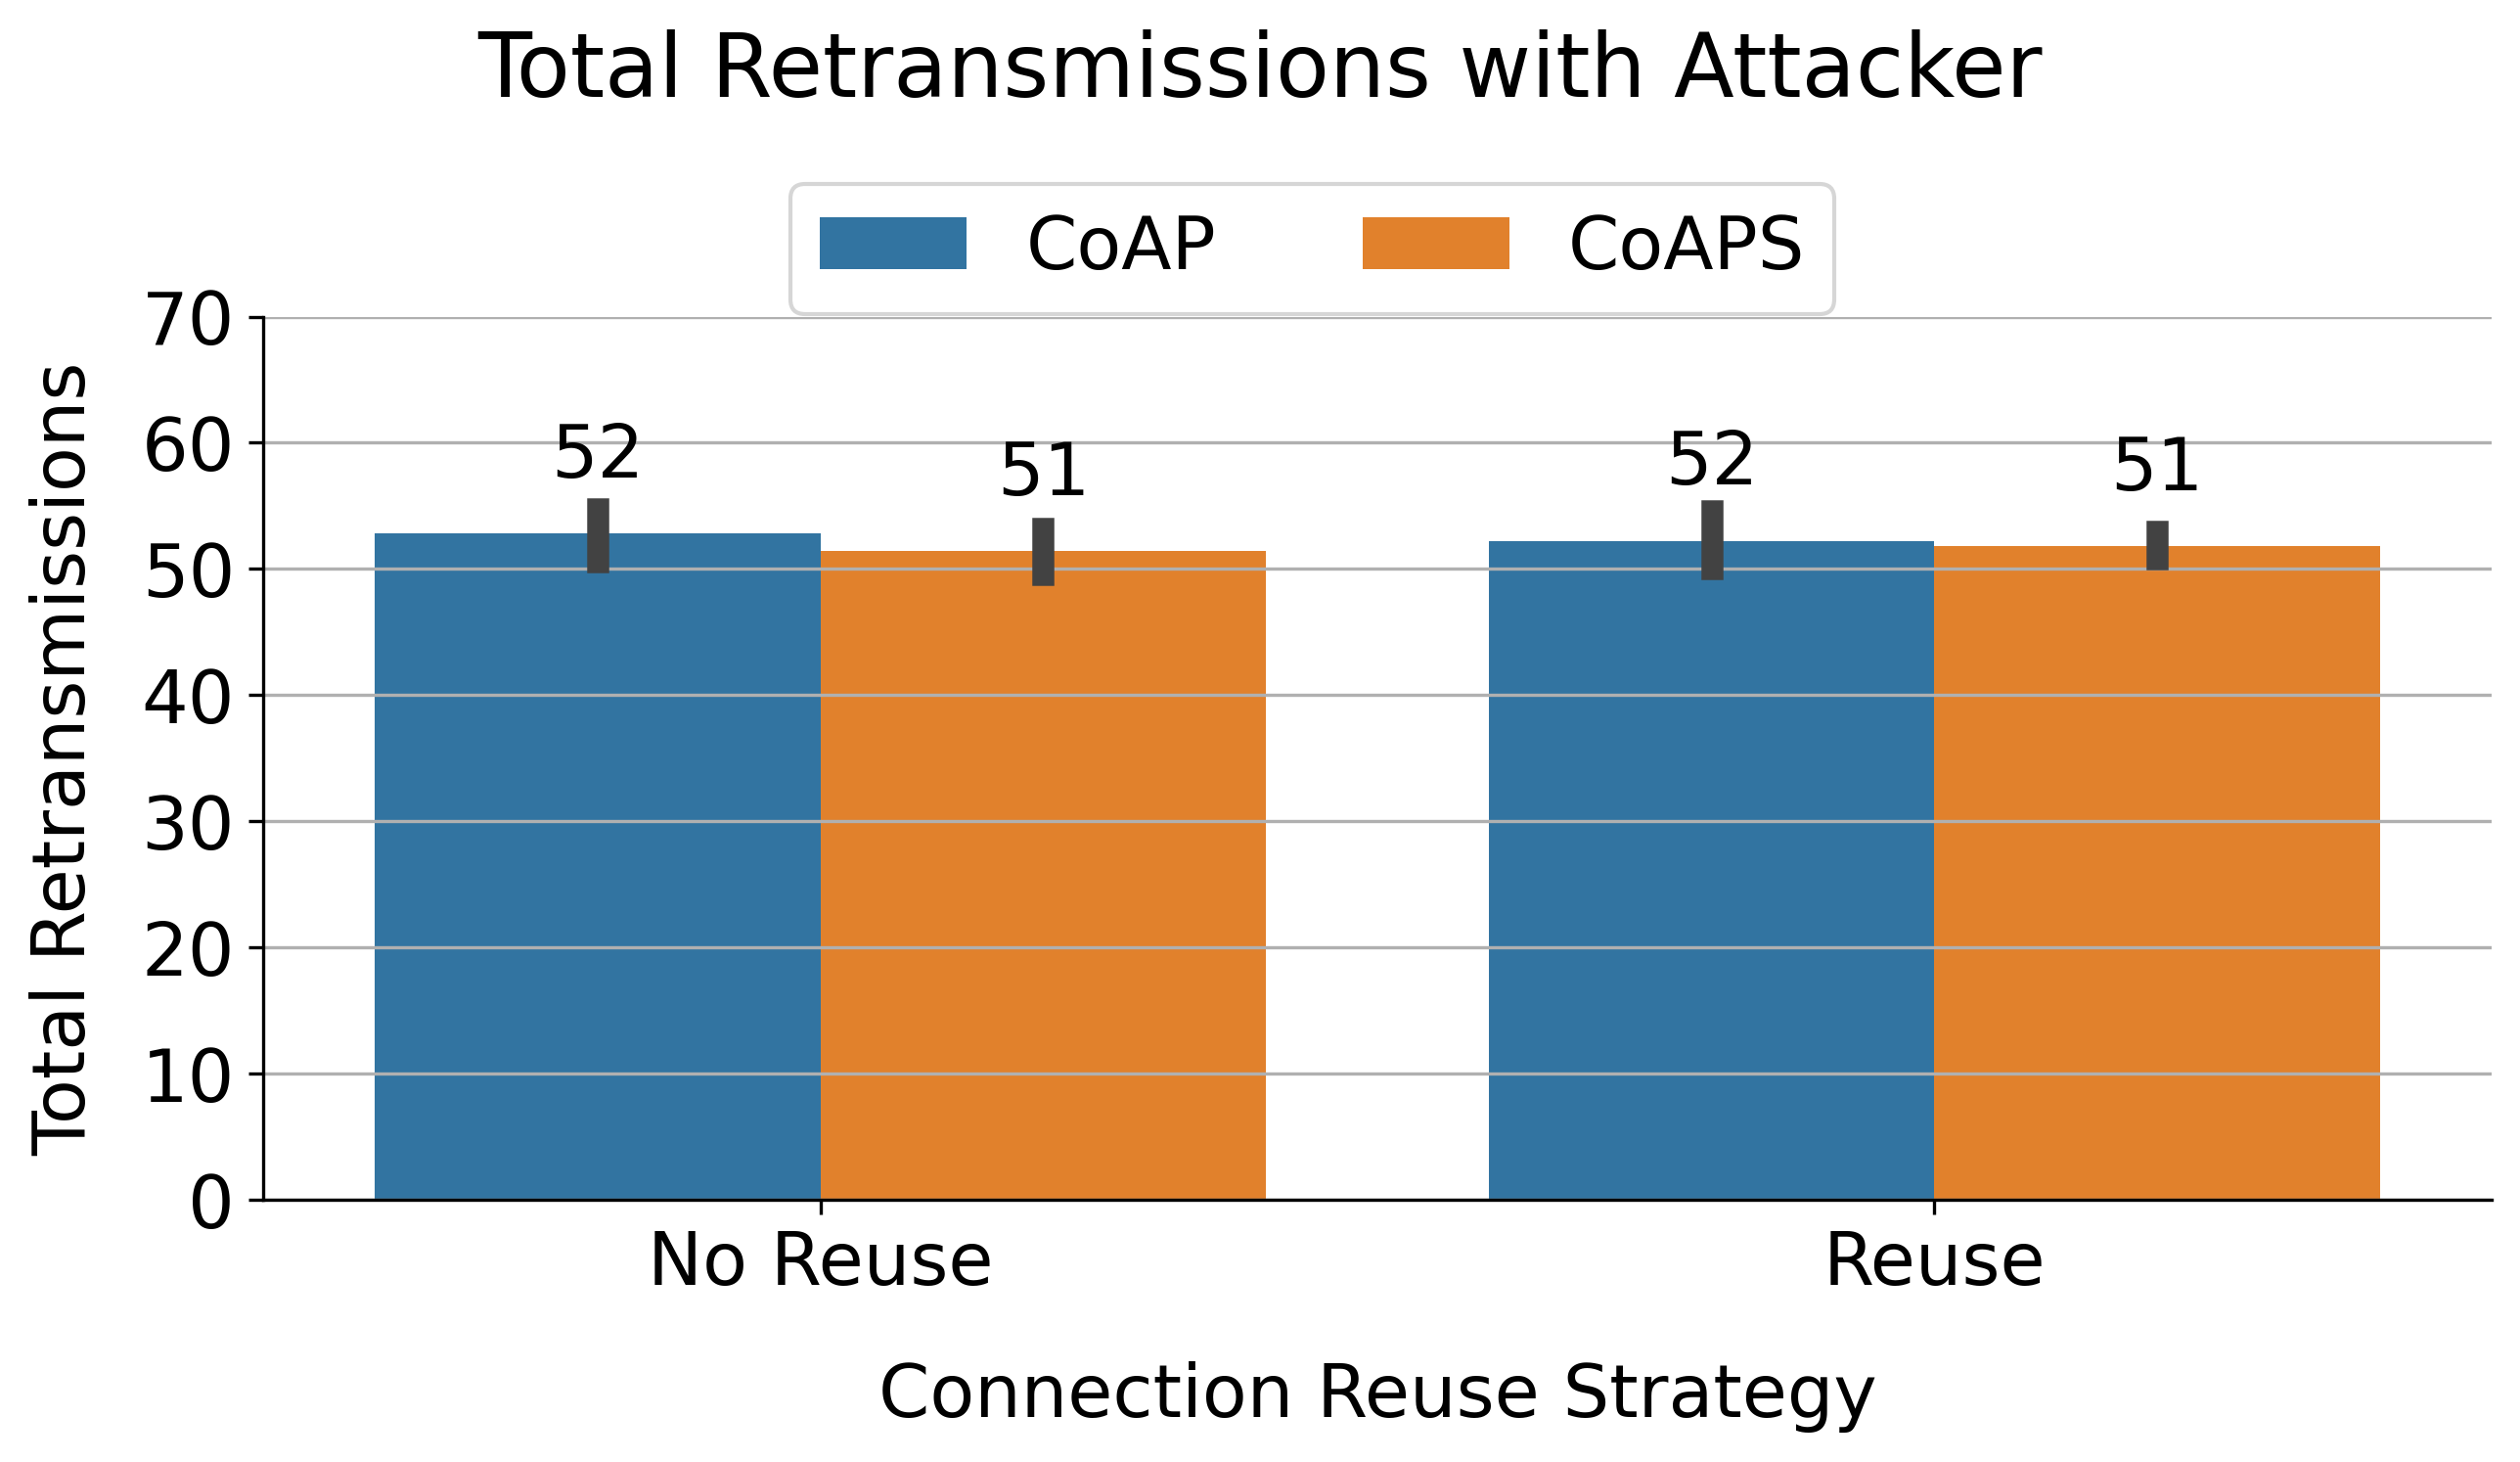

exp_id  \
20  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
21  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
22  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
23  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
24  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
25  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
26  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
27  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
28  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
29  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
30   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
31   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
32   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
33   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
34   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
35   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
36   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
37   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
38   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
39   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

    trial   run_attacker reuse_connections run_proxy_with_dtls  \
20      1  With Attacker          No Reuse                CoAP   
21      2  With Attacker          No Reuse                CoAP   
22      3  With Attacker          No Reuse                CoAP   
23      4  With Attacker          No Reuse                CoAP   
24      5  With Attacker          No Reuse                CoAP   
25      1  With Attacker          No Reuse               CoAPS   
26      2  With Attacker          No Reuse               CoAPS   
27      3  With Attacker          No Reuse               CoAPS   
28      4  With Attacker          N

In [117]:
## Plot retransmissions as a function of clients and protocol.

df = (
  client_rps_df.groupby(by=["exp_id", "trial", "run_attacker", "reuse_connections", "run_proxy_with_dtls"])
  .agg(
    total_num_retransmissions=("total_num_retransmissions", "sum")
  )
  .reset_index()
)

# When running without attacker, there are no retransmissions either way,
# so we ignore that case.
g = sns.catplot(
  data=df[df["run_attacker"] == "With Attacker"],
  kind="bar",
  x="reuse_connections",
  y="total_num_retransmissions",
  hue="run_proxy_with_dtls",
  aspect=1.25,
)

g.set_xlabels("Connection Reuse Strategy", labelpad=15)
g.set_ylabels("Total Retransmissions", labelpad=10)
g.set(
  yticks=np.arange(0,71,10),
)

axes = [
  g.axes[0,0],
]
for ax in axes:
  ax.grid(True, axis="y")
  for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=10)

g.fig.suptitle("Total Retransmissions with Attacker", y=1.01)

sns.move_legend(
  g,
  "upper center",
  bbox_to_anchor=(0.52, 0.93),
  ncol=2,
  title=None,
  frameon=True,
)

plt.tight_layout()
plt.show()

df[df["total_num_retransmissions"] > 0]

In [47]:
%%time

## Determine transaction success rate

# Combine send and receive events for clients.
client_events_df = client_sends_df.merge(client_recvs_df, on=["exp_id", "trial", "observer_id", "message_marker"], how="left")
client_events_df.rename(columns={
  "observe_timestamp_x": "send_timestamp",
  "observe_timestamp_y": "recv_timestamp",
}, inplace=True)
client_events_df["rtt_ms"] = 1e3 * (client_events_df["recv_timestamp"] - client_events_df["send_timestamp"])

# Edge case: sometimes clients will not receive a
# response back at the end of the experiment, so
# we ignore those messages, if any.
grouped_last_nan_indicies_to_remove = (
  client_events_df.reset_index()[
    client_events_df["recv_timestamp"].isna()
  ]
  .groupby(by=["exp_id", "trial", "observer_id", "message_marker"])
  .agg(
    last_nan_recv_timestamp=("recv_timestamp", "last"),
    original_index=("index", "last"),
  )
  .reset_index()
  ["original_index"]
  .unique()
)
client_events_df.drop(index=grouped_last_nan_indicies_to_remove, inplace=True)
client_events_df.reset_index(inplace=True)
client_events_df.drop(columns=["index"], inplace=True)

# Produce the total number of messages, and number 
# messages with a matching successful response.
grouped_client_events_df = (
  client_events_df
  .groupby(["exp_id", "trial", "observer_id"])
  .agg(
    unique_message_markers=("message_marker", "nunique"),
    num_successful_messages=("successful_message", "sum"),
  )
  .reset_index()
)

# Now compute the successful transaction rate.
grouped_client_events_df["transaction_success_rate"] = 100 * grouped_client_events_df["num_successful_messages"] / grouped_client_events_df["unique_message_markers"]

grouped_client_events_df = (
  grouped_client_events_df
  .merge(exp_df, on="exp_id", how="left")
  .replace({
    "run_proxy_with_dtls": {
      True : "CoAPS",
      False: "CoAP",
    },
  })
)

grouped_client_events_df

CPU times: user 1.89 s, sys: 4.04 ms, total: 1.89 s
Wall time: 1.89 s


exp_id  \
0     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                               ...   
315  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
316  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
317  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
318  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
319  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id  unique_message_markers num_successful_messages  \
0        1     client1                    1528                    1528   
1        1     client2                    1533                    1533   
2        1     client3                    1534                    1534   
3        1     client4                    1534                    1534   
4        1     client5                    1535                    1535   
..     ...         ...                     ...                     ...   
315      5     client4                    1573                    1575   
316      5     client5                    1576                    1579   
317      5     client6                    1574                    1572   
318      5     client7                    1575                    1579   
319      5     client8                    1575                    1572   

    transaction_success_rate attacker_rate  server_connections  \
0                      100.0         0mbps                 256   
1                      100.0         0mbps                 256   
2                      100.0         0mbps                 256   
3                      100.0         0mbps                 256   
4                      100.0         0mbps                 256   
..                       ...           ...                 ...   
315               100.127146       100mbps                 256   
316               100.190355       100mbps                 256   
317                99.872935       100mbps                 256   
318               100.253968       100mbps                 256   
319                99.809524       100mbps                 256   

     max_keep_alive_requests  num_clients  ...  \
0                          0            8  ...   
1                          0            8  ...   
2                          0            8  ...   
3                          0            8  ...   
4                          0            8  ...   
..                       ...          ...  ...   
315                        0            8  ...   
316                        0            8  ...   
317      

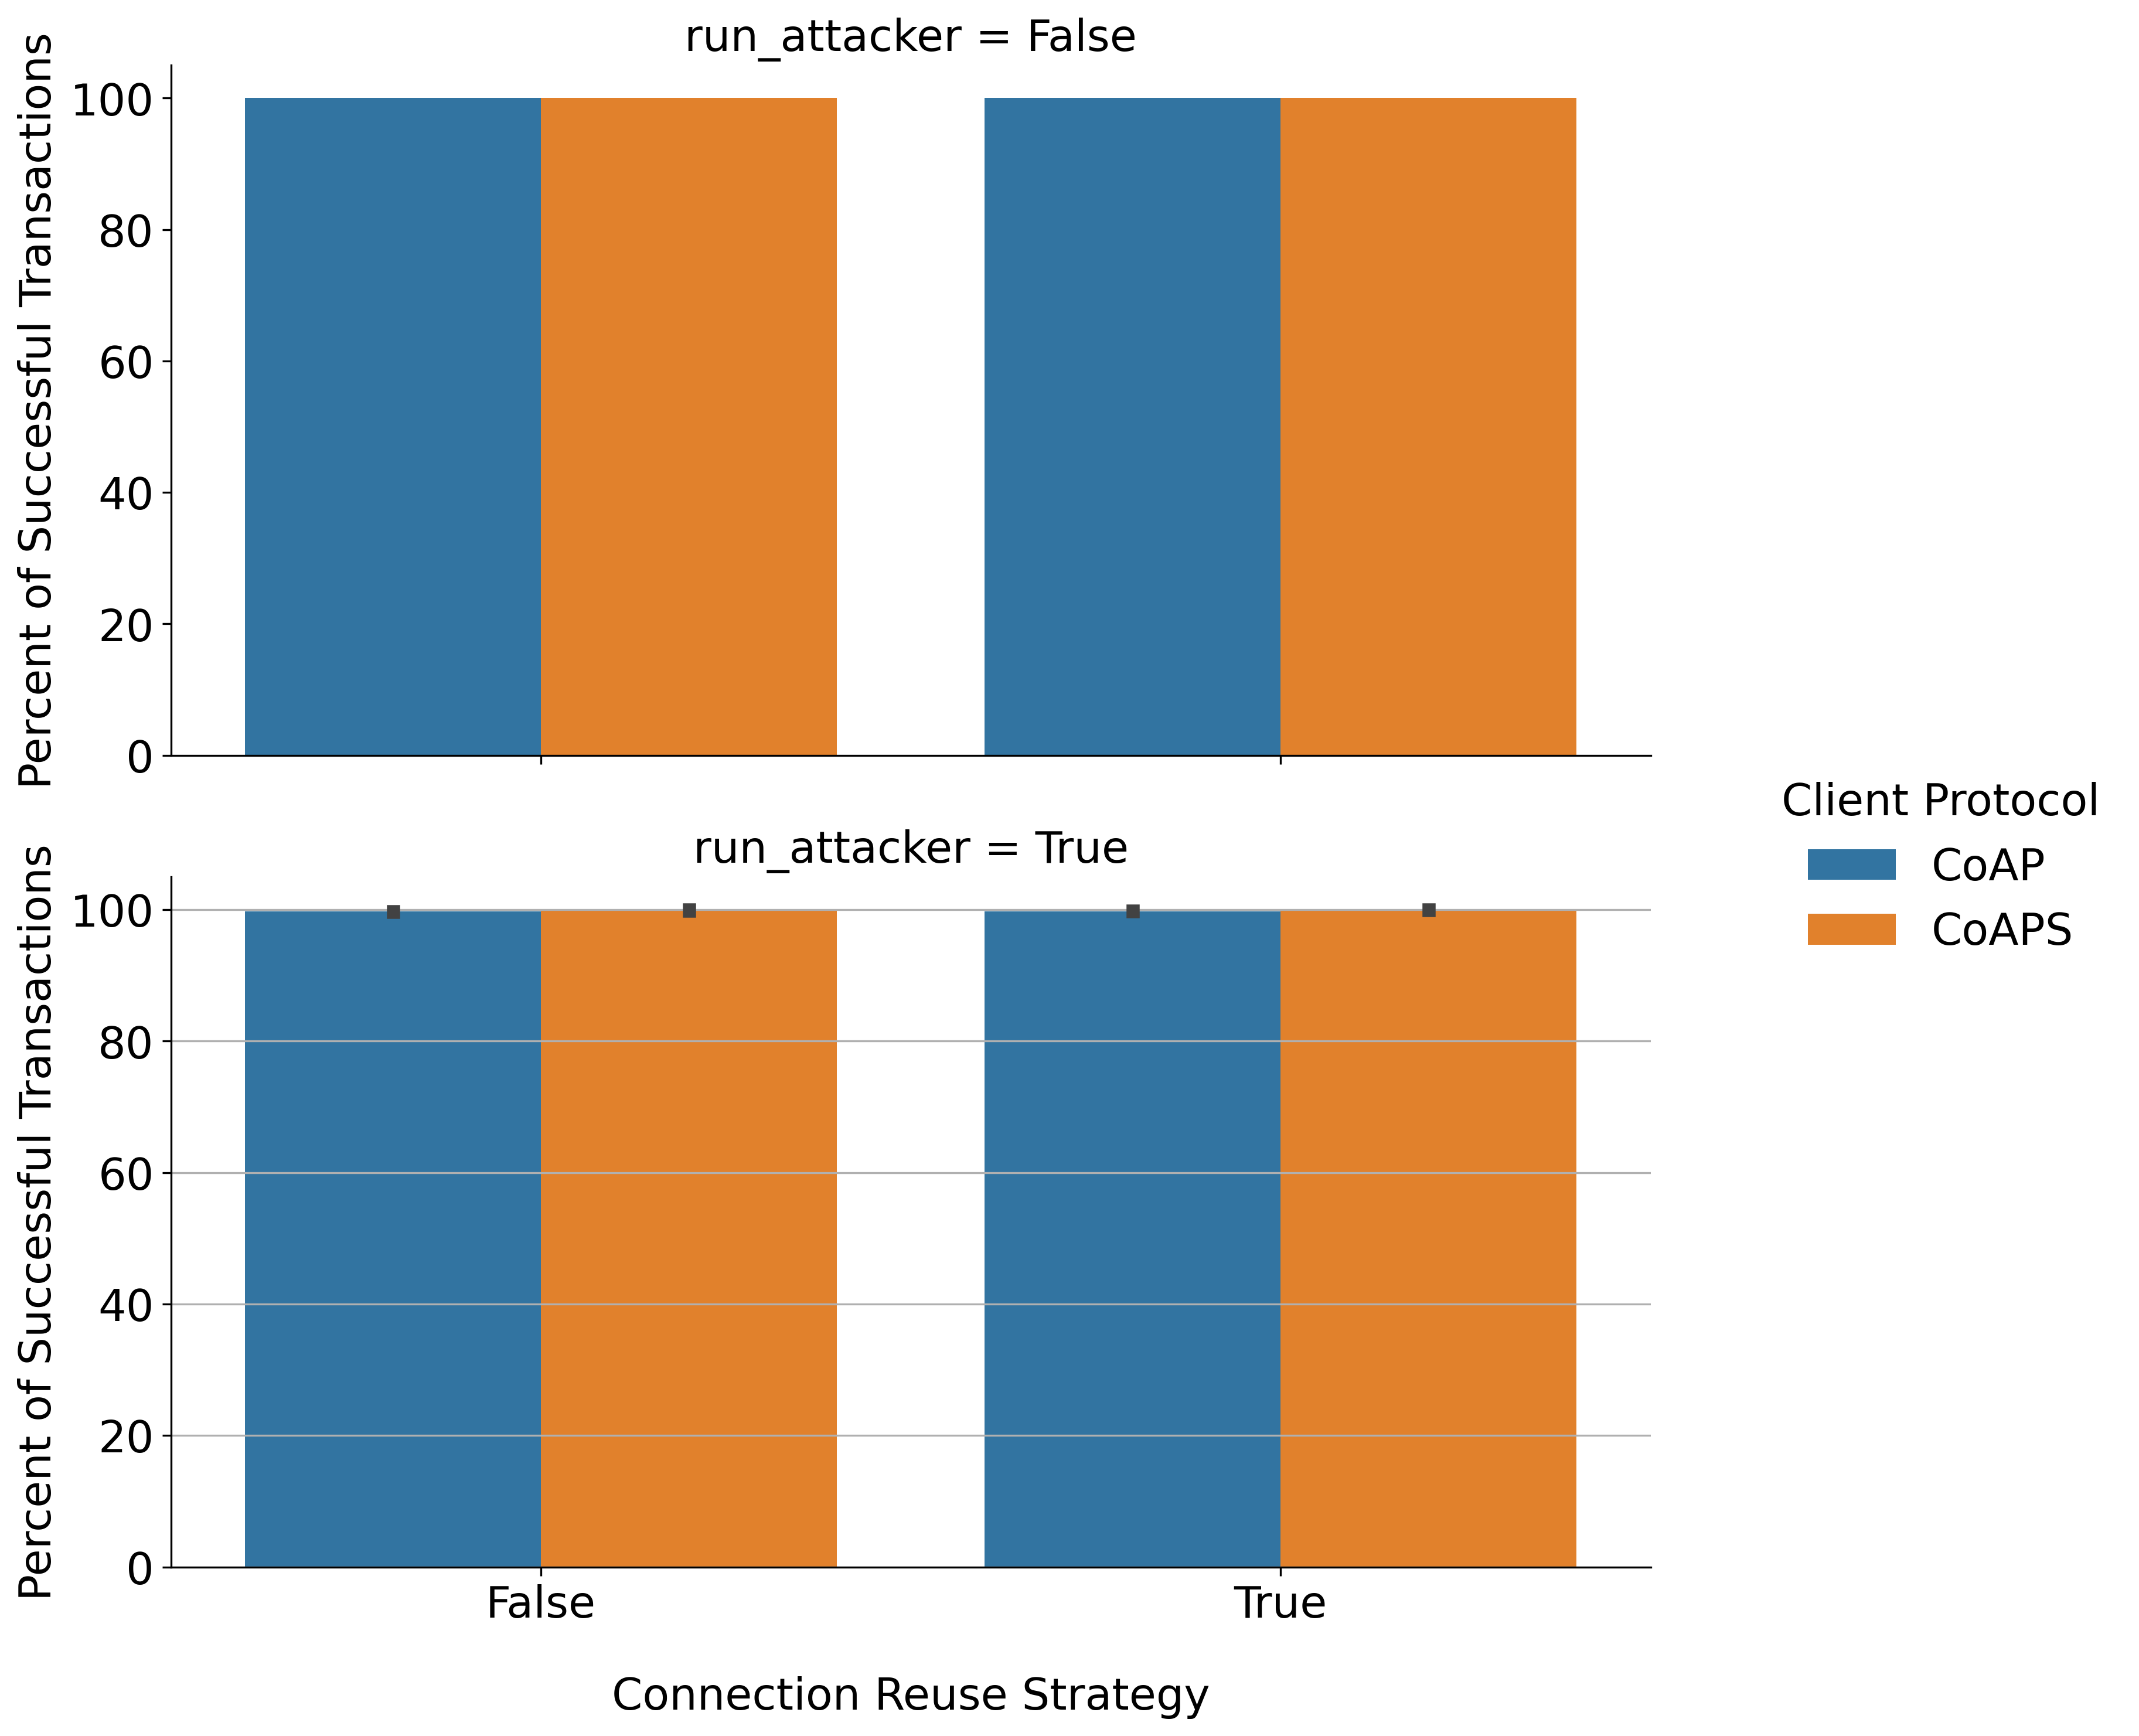

exp_id  \
161  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
162  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
163  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
164  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
165  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                                ...   
311   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
313   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
314   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
317   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
319   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id  unique_message_markers num_successful_messages  \
161      1     client2                    1086                    1082   
162      1     client3                    1088                    1082   
163      1     client4                    1088                    1084   
164      1     client5                    1088                    1085   
165      1     client6                    1039                    1038   
..     ...         ...                     ...                     ...   
311      4     client8                    1571                    1567   
313      5     client2                    1570                    1565   
314      5     client3                    1572                    1571   
317      5     client6                    1574                    1572   
319      5     client8                    1575                    1572   

    transaction_success_rate attacker_rate  server_connections  \
161                99.631676       100mbps                 256   
162                99.448529       100mbps                 256   
163                99.632353       100mbps                 256   
164                99.724265       100mbps                 256   
165                99.903754       100mbps                 256   
..                       ...           ...                 ...   
311                99.745385       100mbps                 256   
313                99.681529       100mbps                 256   
314                99.936387       100mbps                 256   
317                99.872935       100mbps                 256   
319                99.809524       100mbps                 256   

     max_keep_alive_requests  num_clients  ...  \
161                        0            8  ...   
162                        0            8  ...   
163                        0            8  ...   
164                        0            8  ...   
165                        0            8  ...   
..                       ...          ...  ...   
311                        0            8  ...   
313                        0            8  ...  

In [48]:
df = grouped_client_events_df

g = sns.catplot(
  data=df,
  kind="bar",
  x="reuse_connections",
  y="transaction_success_rate",
  hue="run_proxy_with_dtls",
  row="run_attacker",
  aspect=2,
)

g.set_xlabels("Connection Reuse Strategy", labelpad=20)
g.set_ylabels("Percent of Successful Transactions")
g.legend.set_title("Client Protocol")

plt.grid(True, axis="y")
plt.show()

grouped_client_events_df[
  grouped_client_events_df["transaction_success_rate"] < 100
]

In [49]:
df

exp_id  \
0     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                               ...   
315  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
316  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
317  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
318  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
319  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id  unique_message_markers num_successful_messages  \
0        1     client1                    1528                    1528   
1        1     client2                    1533                    1533   
2        1     client3                    1534                    1534   
3        1     client4                    1534                    1534   
4        1     client5                    1535                    1535   
..     ...         ...                     ...                     ...   
315      5     client4                    1573                    1575   
316      5     client5                    1576                    1579   
317      5     client6                    1574                    1572   
318      5     client7                    1575                    1579   
319      5     client8                    1575                    1572   

    transaction_success_rate attacker_rate  server_connections  \
0                      100.0         0mbps                 256   
1                      100.0         0mbps                 256   
2                      100.0         0mbps                 256   
3                      100.0         0mbps                 256   
4                      100.0         0mbps                 256   
..                       ...           ...                 ...   
315               100.127146       100mbps                 256   
316               100.190355       100mbps                 256   
317                99.872935       100mbps                 256   
318               100.253968       100mbps                 256   
319                99.809524       100mbps                 256   

     max_keep_alive_requests  num_clients  ...  \
0                          0            8  ...   
1                          0            8  ...   
2                          0            8  ...   
3                          0            8  ...   
4                          0            8  ...   
..                       ...          ...  ...   
315                        0            8  ...   
316                        0            8  ...   
317      

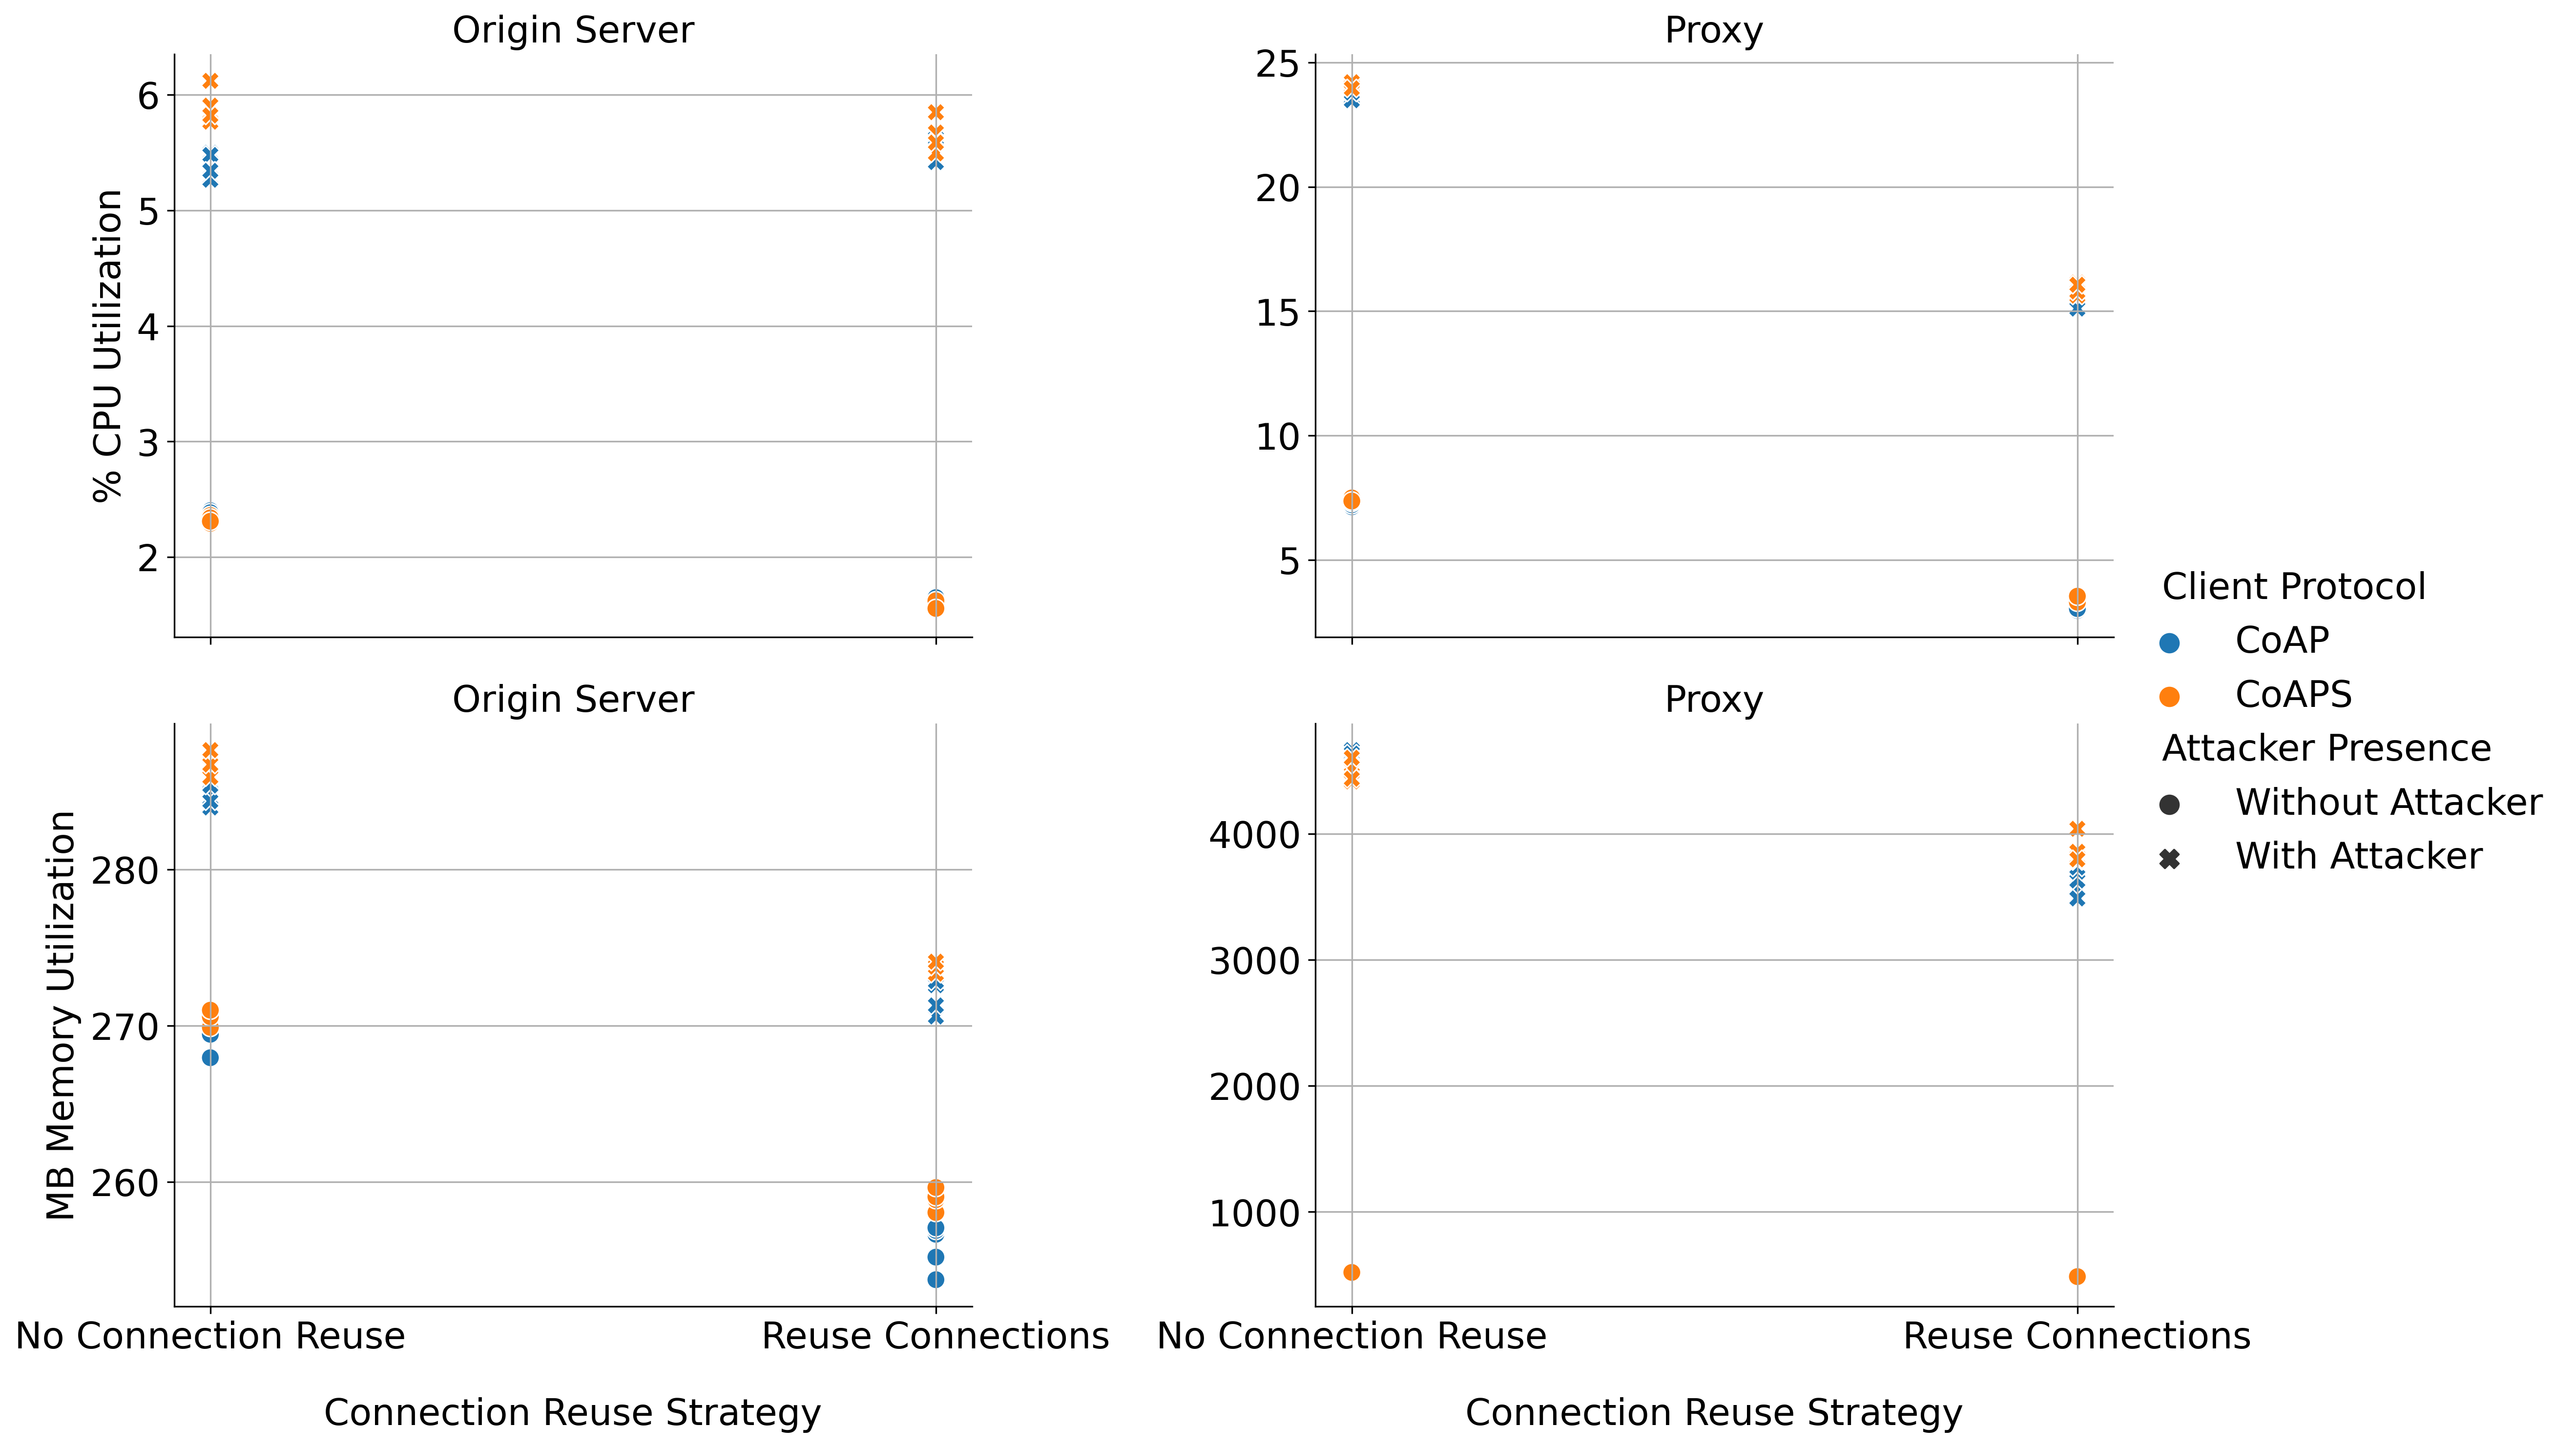

CPU times: user 2.39 s, sys: 302 ms, total: 2.69 s
Wall time: 2.41 s


exp_id  \
0     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                               ...   
155  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
156  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
157  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
158  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
159  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial    observer_id            metric_type    avg_value  min_value  \
0        1  Origin Server      % CPU Utilization     2.380000        0.4   
1        1          Proxy      % CPU Utilization     7.144286        0.5   
2        1  Origin Server  MB Memory Utilization   267.950413      245.0   
3        1          Proxy  MB Memory Utilization   515.880795      264.0   
4        2  Origin Server      % CPU Utilization     2.401429        0.4   
..     ...            ...                    ...          ...        ...   
155      4          Proxy  MB Memory Utilization  3856.508333      268.0   
156      5  Origin Server      % CPU Utilization     5.586429        0.4   
157      5          Proxy      % CPU Utilization    16.064286        0.4   
158      5  Origin Server  MB Memory Utilization   274.095868      251.0   
159      5          Proxy  MB Memory Utilization  3796.620000      268.0   

     max_value attacker_rate  server_connections  max_keep_alive_requests  \
0         10.8         0mbps                 256                        0   
1         22.1         0mbps                 256                        0   
2        271.0         0mbps                 256                        0   
3        537.0         0mbps                 256                        0   
4         10.0         0mbps                 256                        0   
..         ...           ...                 ...                      ...   
155     6450.0       100mbps                 256                        0   
156       23.4       100mbps                 256                        0   
157       91.9       100mbps                 256                        0   
158      301.0       100mbps                 256                        0   
159     6280.0       100mbps                 256                        0   

     ...                             topology_name  num_proxy_connections  \
0    ...  thesis_cloud_proxy_and_internet_attacker                     50   
1    ...  thesis_cloud_proxy_and_internet_attacker                     50   
2    ...  thesis_cloud_proxy_and_internet_attacker                     5

In [50]:
%%time

## Measure proxy and server metrics.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
  .replace(value_map_replacement)
  .rename(columns={
    "run_attacker": "Attacker Presence",
    "run_proxy_with_dtls": "Client Protocol",
  })
)

g = sns.relplot(
  data=df,
  kind="scatter",
  x="reuse_connections",
  y="avg_value",
  col="observer_id",
  row="metric_type",
  hue="Client Protocol",
  style="Attacker Presence",
  facet_kws={
    "sharey": False,
    "sharex": True,
  },
  aspect=1.5,
)

g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set_xlabels("Connection Reuse Strategy", labelpad=20)
g.set_ylabels("Average Metric Value")

g.axes[0,0].set_ylabel("% CPU Utilization")
g.axes[0,1].set_ylabel("")
# # g.axes[0,0].set_ylim(0,4)
# # g.axes[0,1].set_ylim(0,4)

g.axes[1,0].set_ylabel("MB Memory Utilization")
g.axes[1,1].set_ylabel("")
# # g.axes[1,0].set_ylim(250, 500)
# # g.axes[1,1].set_ylim(250, 500)

g.axes[0,0].grid(True, axis="both")
g.axes[0,1].grid(True, axis="both")
g.axes[1,0].grid(True, axis="both")
g.axes[1,1].grid(True, axis="both")

plt.show()

df

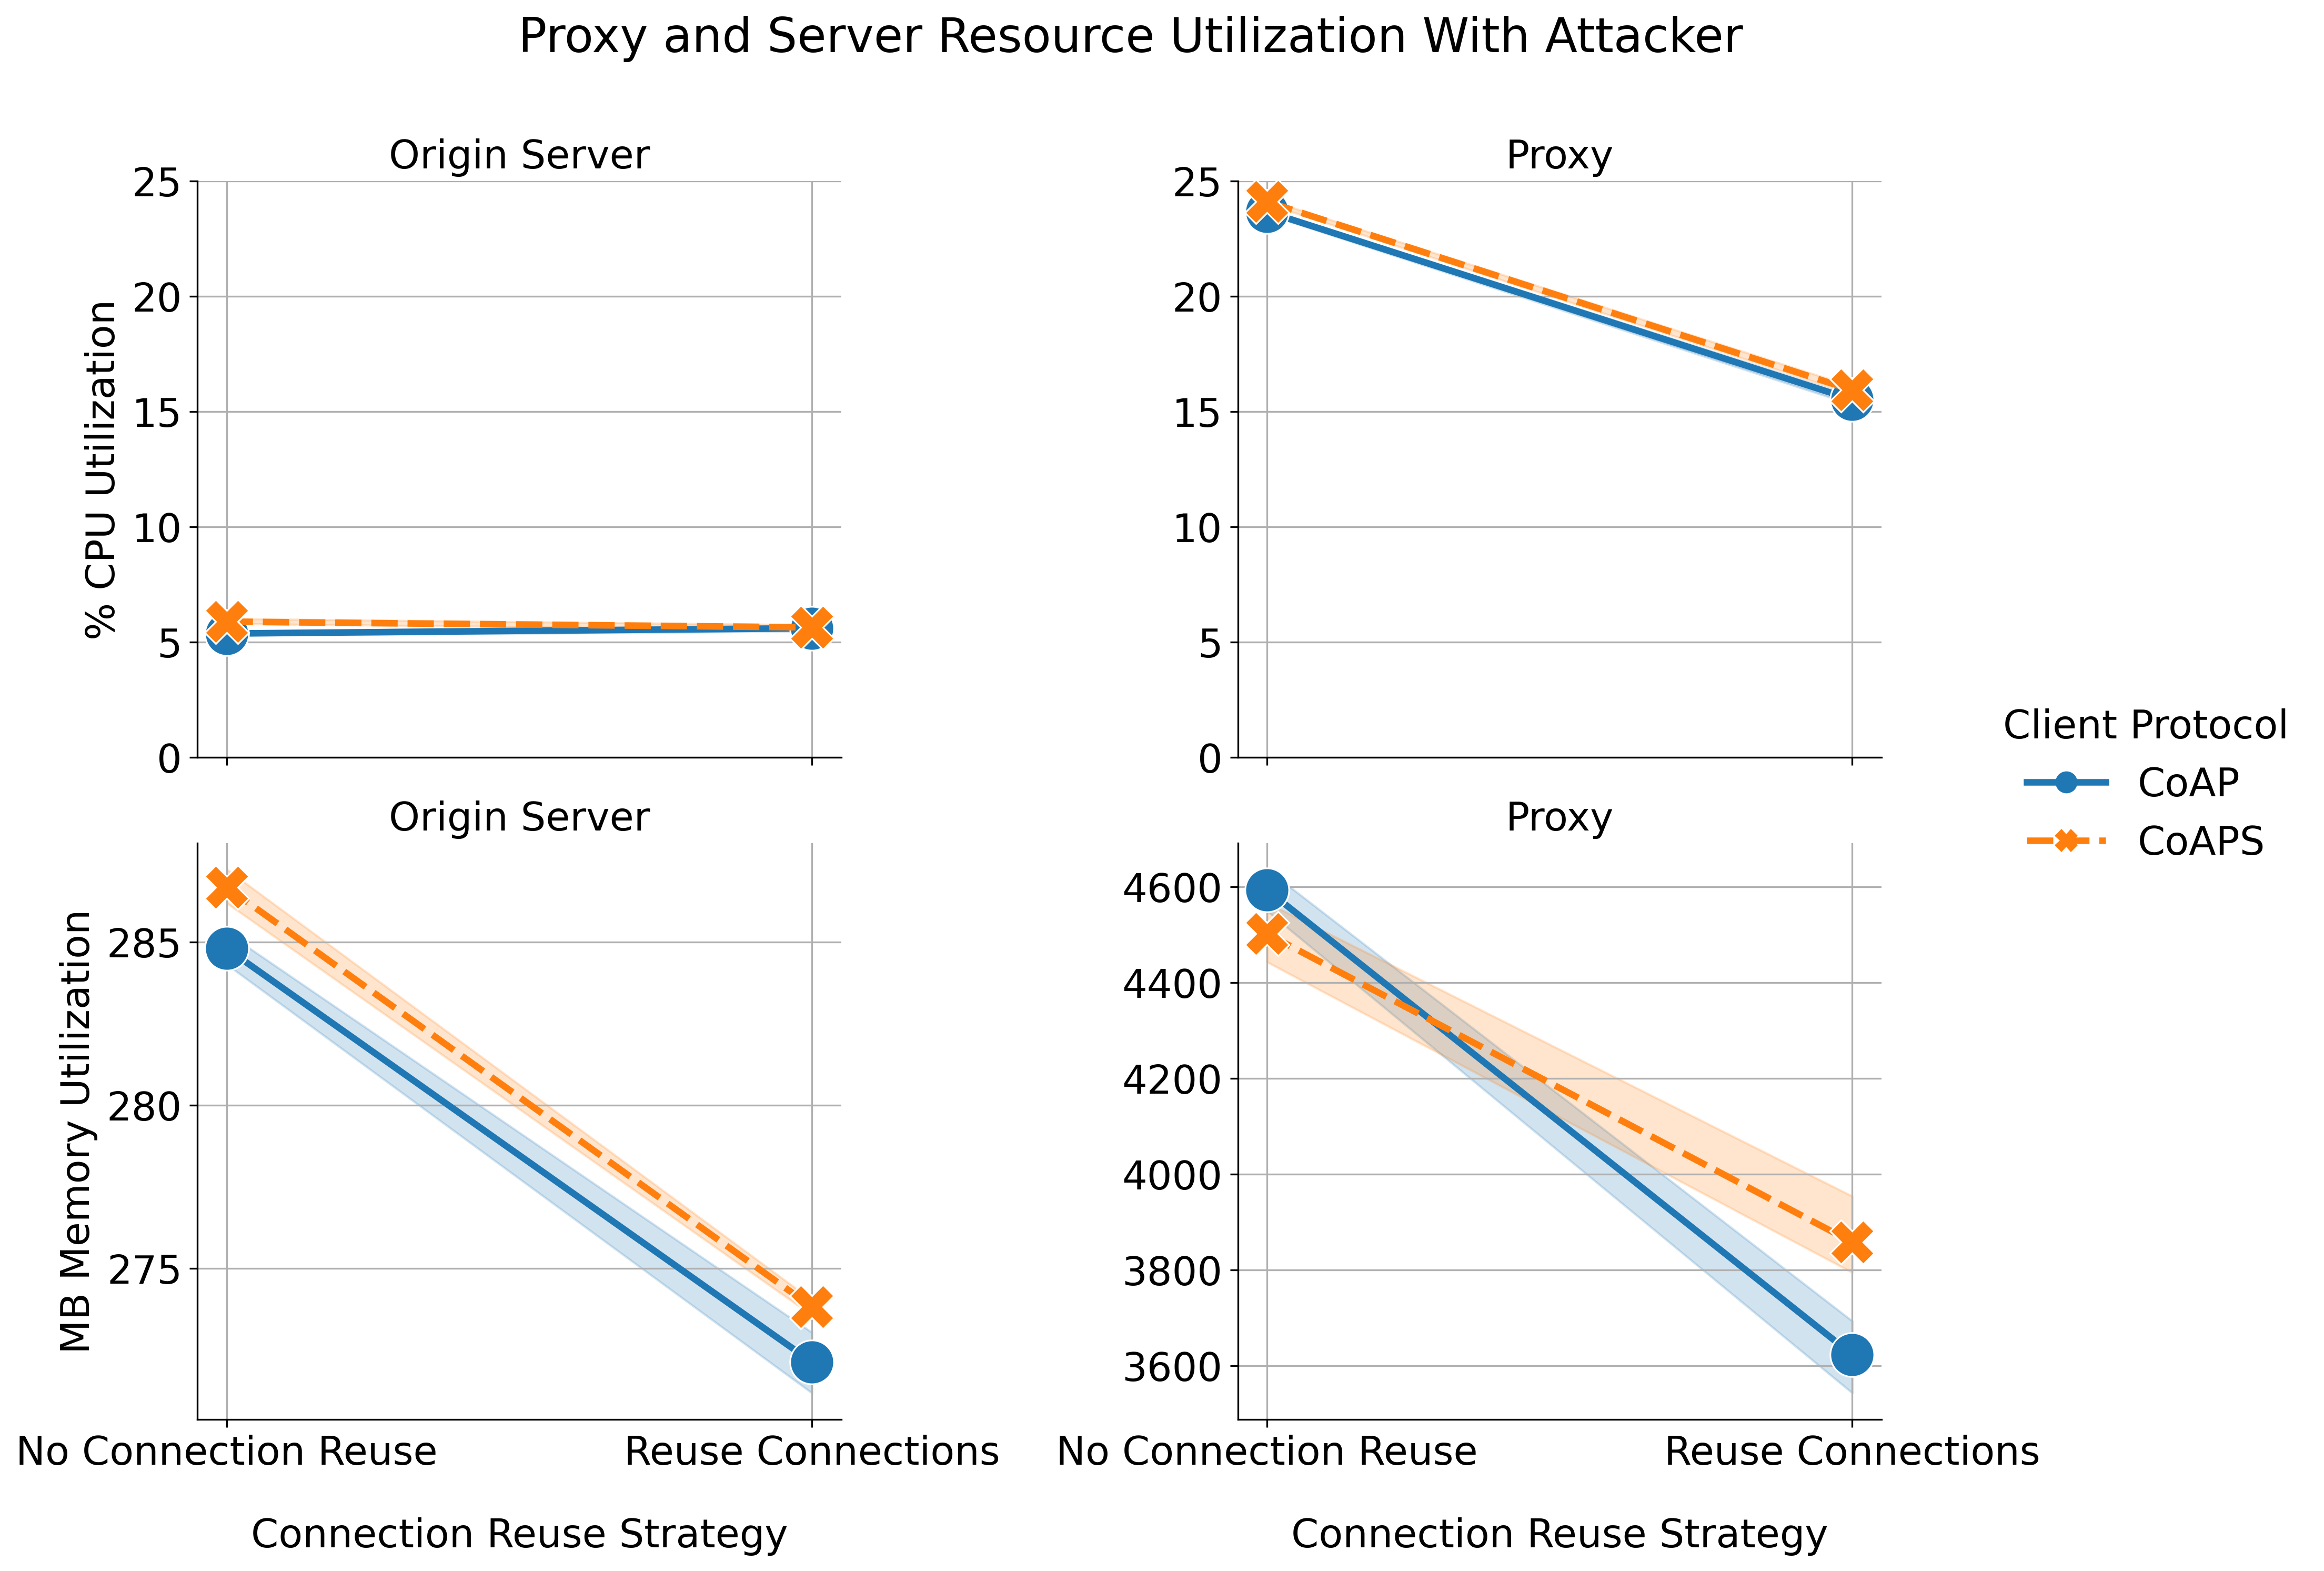

CPU times: user 2.64 s, sys: 329 ms, total: 2.97 s
Wall time: 2.67 s


exp_id  \
0     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                               ...   
155  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
156  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
157  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
158  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
159  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial    observer_id            metric_type    avg_value  min_value  \
0        1  Origin Server      % CPU Utilization     2.380000        0.4   
1        1          Proxy      % CPU Utilization     7.144286        0.5   
2        1  Origin Server  MB Memory Utilization   267.950413      245.0   
3        1          Proxy  MB Memory Utilization   515.880795      264.0   
4        2  Origin Server      % CPU Utilization     2.401429        0.4   
..     ...            ...                    ...          ...        ...   
155      4          Proxy  MB Memory Utilization  3856.508333      268.0   
156      5  Origin Server      % CPU Utilization     5.586429        0.4   
157      5          Proxy      % CPU Utilization    16.064286        0.4   
158      5  Origin Server  MB Memory Utilization   274.095868      251.0   
159      5          Proxy  MB Memory Utilization  3796.620000      268.0   

     max_value attacker_rate  server_connections  max_keep_alive_requests  \
0         10.8         0mbps                 256                        0   
1         22.1         0mbps                 256                        0   
2        271.0         0mbps                 256                        0   
3        537.0         0mbps                 256                        0   
4         10.0         0mbps                 256                        0   
..         ...           ...                 ...                      ...   
155     6450.0       100mbps                 256                        0   
156       23.4       100mbps                 256                        0   
157       91.9       100mbps                 256                        0   
158      301.0       100mbps                 256                        0   
159     6280.0       100mbps                 256                        0   

     ...                             topology_name  num_proxy_connections  \
0    ...  thesis_cloud_proxy_and_internet_attacker                     50   
1    ...  thesis_cloud_proxy_and_internet_attacker                     50   
2    ...  thesis_cloud_proxy_and_internet_attacker                     5

In [51]:
%%time

## Measure proxy and server metrics with attacker.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
  .replace(value_map_replacement)
)

g = sns.relplot(
  data=df[df["run_attacker"] == "With Attacker"],
  kind="line",
  x="reuse_connections",
  y="avg_value",
  col="observer_id",
  row="metric_type",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=20,
  facet_kws={
    "sharey": False,
    "sharex": True,
  },
  aspect=1.25,
)

g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.legend.set_title("Client Protocol")
g.set_xlabels("Connection Reuse Strategy", labelpad=20)
g.set_ylabels("Average Metric Value")

g.axes[0,0].set_ylabel("% CPU Utilization")
g.axes[0,1].set_ylabel("")
g.axes[0,0].set_ylim(0,25)
g.axes[0,1].set_ylim(0,25)

g.axes[1,0].set_ylabel("MB Memory Utilization")
g.axes[1,1].set_ylabel("")

g.axes[0,0].grid(True, axis="both")
g.axes[0,1].grid(True, axis="both")
g.axes[1,0].grid(True, axis="both")
g.axes[1,1].grid(True, axis="both")

g.fig.suptitle("Proxy and Server Resource Utilization With Attacker")
g.fig.subplots_adjust(top=0.875)

plt.show()

df

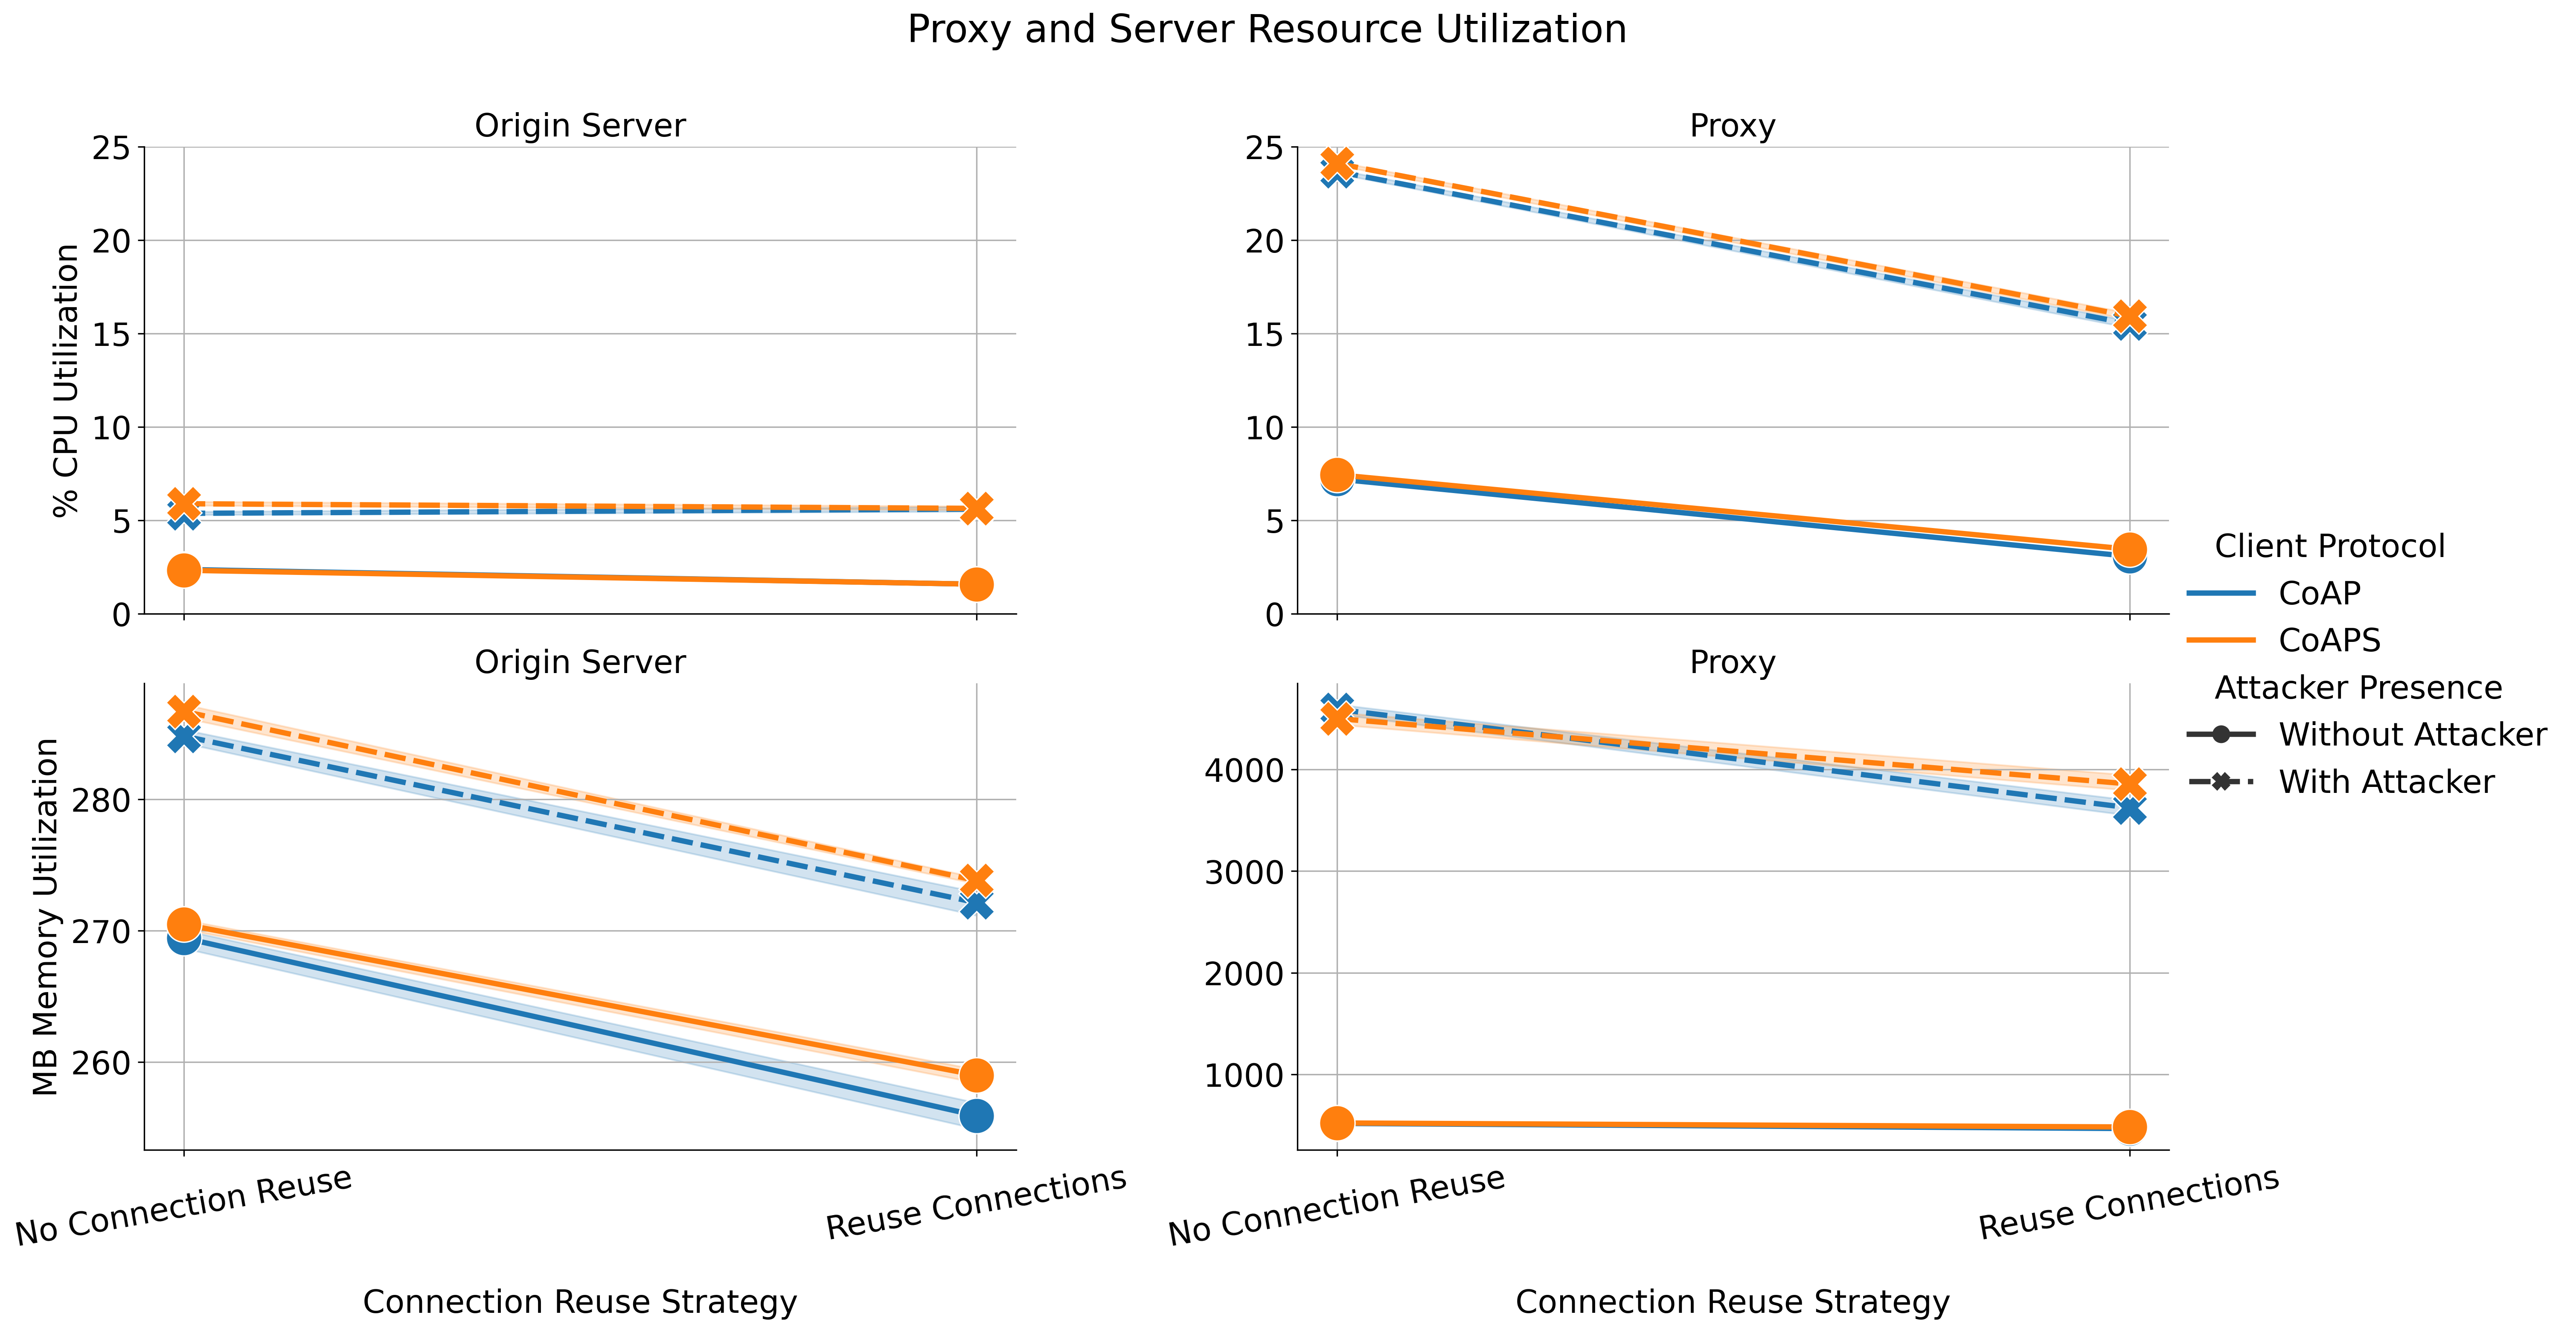

CPU times: user 3.65 s, sys: 380 ms, total: 4.03 s
Wall time: 3.73 s


exp_id  \
0     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                               ...   
155  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
156  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
157  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
158  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
159  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial    observer_id            metric_type    avg_value  min_value  \
0        1  Origin Server      % CPU Utilization     2.380000        0.4   
1        1          Proxy      % CPU Utilization     7.144286        0.5   
2        1  Origin Server  MB Memory Utilization   267.950413      245.0   
3        1          Proxy  MB Memory Utilization   515.880795      264.0   
4        2  Origin Server      % CPU Utilization     2.401429        0.4   
..     ...            ...                    ...          ...        ...   
155      4          Proxy  MB Memory Utilization  3856.508333      268.0   
156      5  Origin Server      % CPU Utilization     5.586429        0.4   
157      5          Proxy      % CPU Utilization    16.064286        0.4   
158      5  Origin Server  MB Memory Utilization   274.095868      251.0   
159      5          Proxy  MB Memory Utilization  3796.620000      268.0   

     max_value attacker_rate  server_connections  max_keep_alive_requests  \
0         10.8         0mbps                 256                        0   
1         22.1         0mbps                 256                        0   
2        271.0         0mbps                 256                        0   
3        537.0         0mbps                 256                        0   
4         10.0         0mbps                 256                        0   
..         ...           ...                 ...                      ...   
155     6450.0       100mbps                 256                        0   
156       23.4       100mbps                 256                        0   
157       91.9       100mbps                 256                        0   
158      301.0       100mbps                 256                        0   
159     6280.0       100mbps                 256                        0   

     ...                             topology_name  num_proxy_connections  \
0    ...  thesis_cloud_proxy_and_internet_attacker                     50   
1    ...  thesis_cloud_proxy_and_internet_attacker                     50   
2    ...  thesis_cloud_proxy_and_internet_attacker                     5

In [52]:
%%time

## Measure proxy and server metrics with/out attacker.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
  .replace(value_map_replacement)
  .rename(columns={
    "run_attacker": "Attacker Presence",
    "run_proxy_with_dtls": "Client Protocol",
  })
)

g = sns.relplot(
  data=df,
  kind="line",
  x="reuse_connections",
  y="avg_value",
  col="observer_id",
  row="metric_type",
  style="Attacker Presence",
  hue="Client Protocol",
  markers=True,
  markersize=20,
  facet_kws={
    "sharey": False,
    "sharex": True,
  },
  aspect=1.75,
)

g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set_xlabels("Connection Reuse Strategy", labelpad=20)
g.set_ylabels("Average Metric Value")

g.axes[0,0].set_ylabel("% CPU Utilization")
g.axes[0,1].set_ylabel("")
g.axes[0,0].set_ylim(0,25)
g.axes[0,1].set_ylim(0,25)
g.axes[0,0].set_yticks(np.arange(0,26,5))
g.axes[0,1].set_yticks(np.arange(0,26,5))

g.axes[1,0].set_ylabel("MB Memory Utilization")
g.axes[1,1].set_ylabel("")
g.axes[1,1].set_yticks(np.arange(1000,4501,1000))

g.axes[0,0].grid(True, axis="both")
g.axes[0,1].grid(True, axis="both")
g.axes[1,0].grid(True, axis="both")
g.axes[1,1].grid(True, axis="both")

g.set_xticklabels(rotation=10)

g.fig.suptitle("Proxy and Server Resource Utilization")
g.fig.subplots_adjust(top=0.875)

plt.show()

df

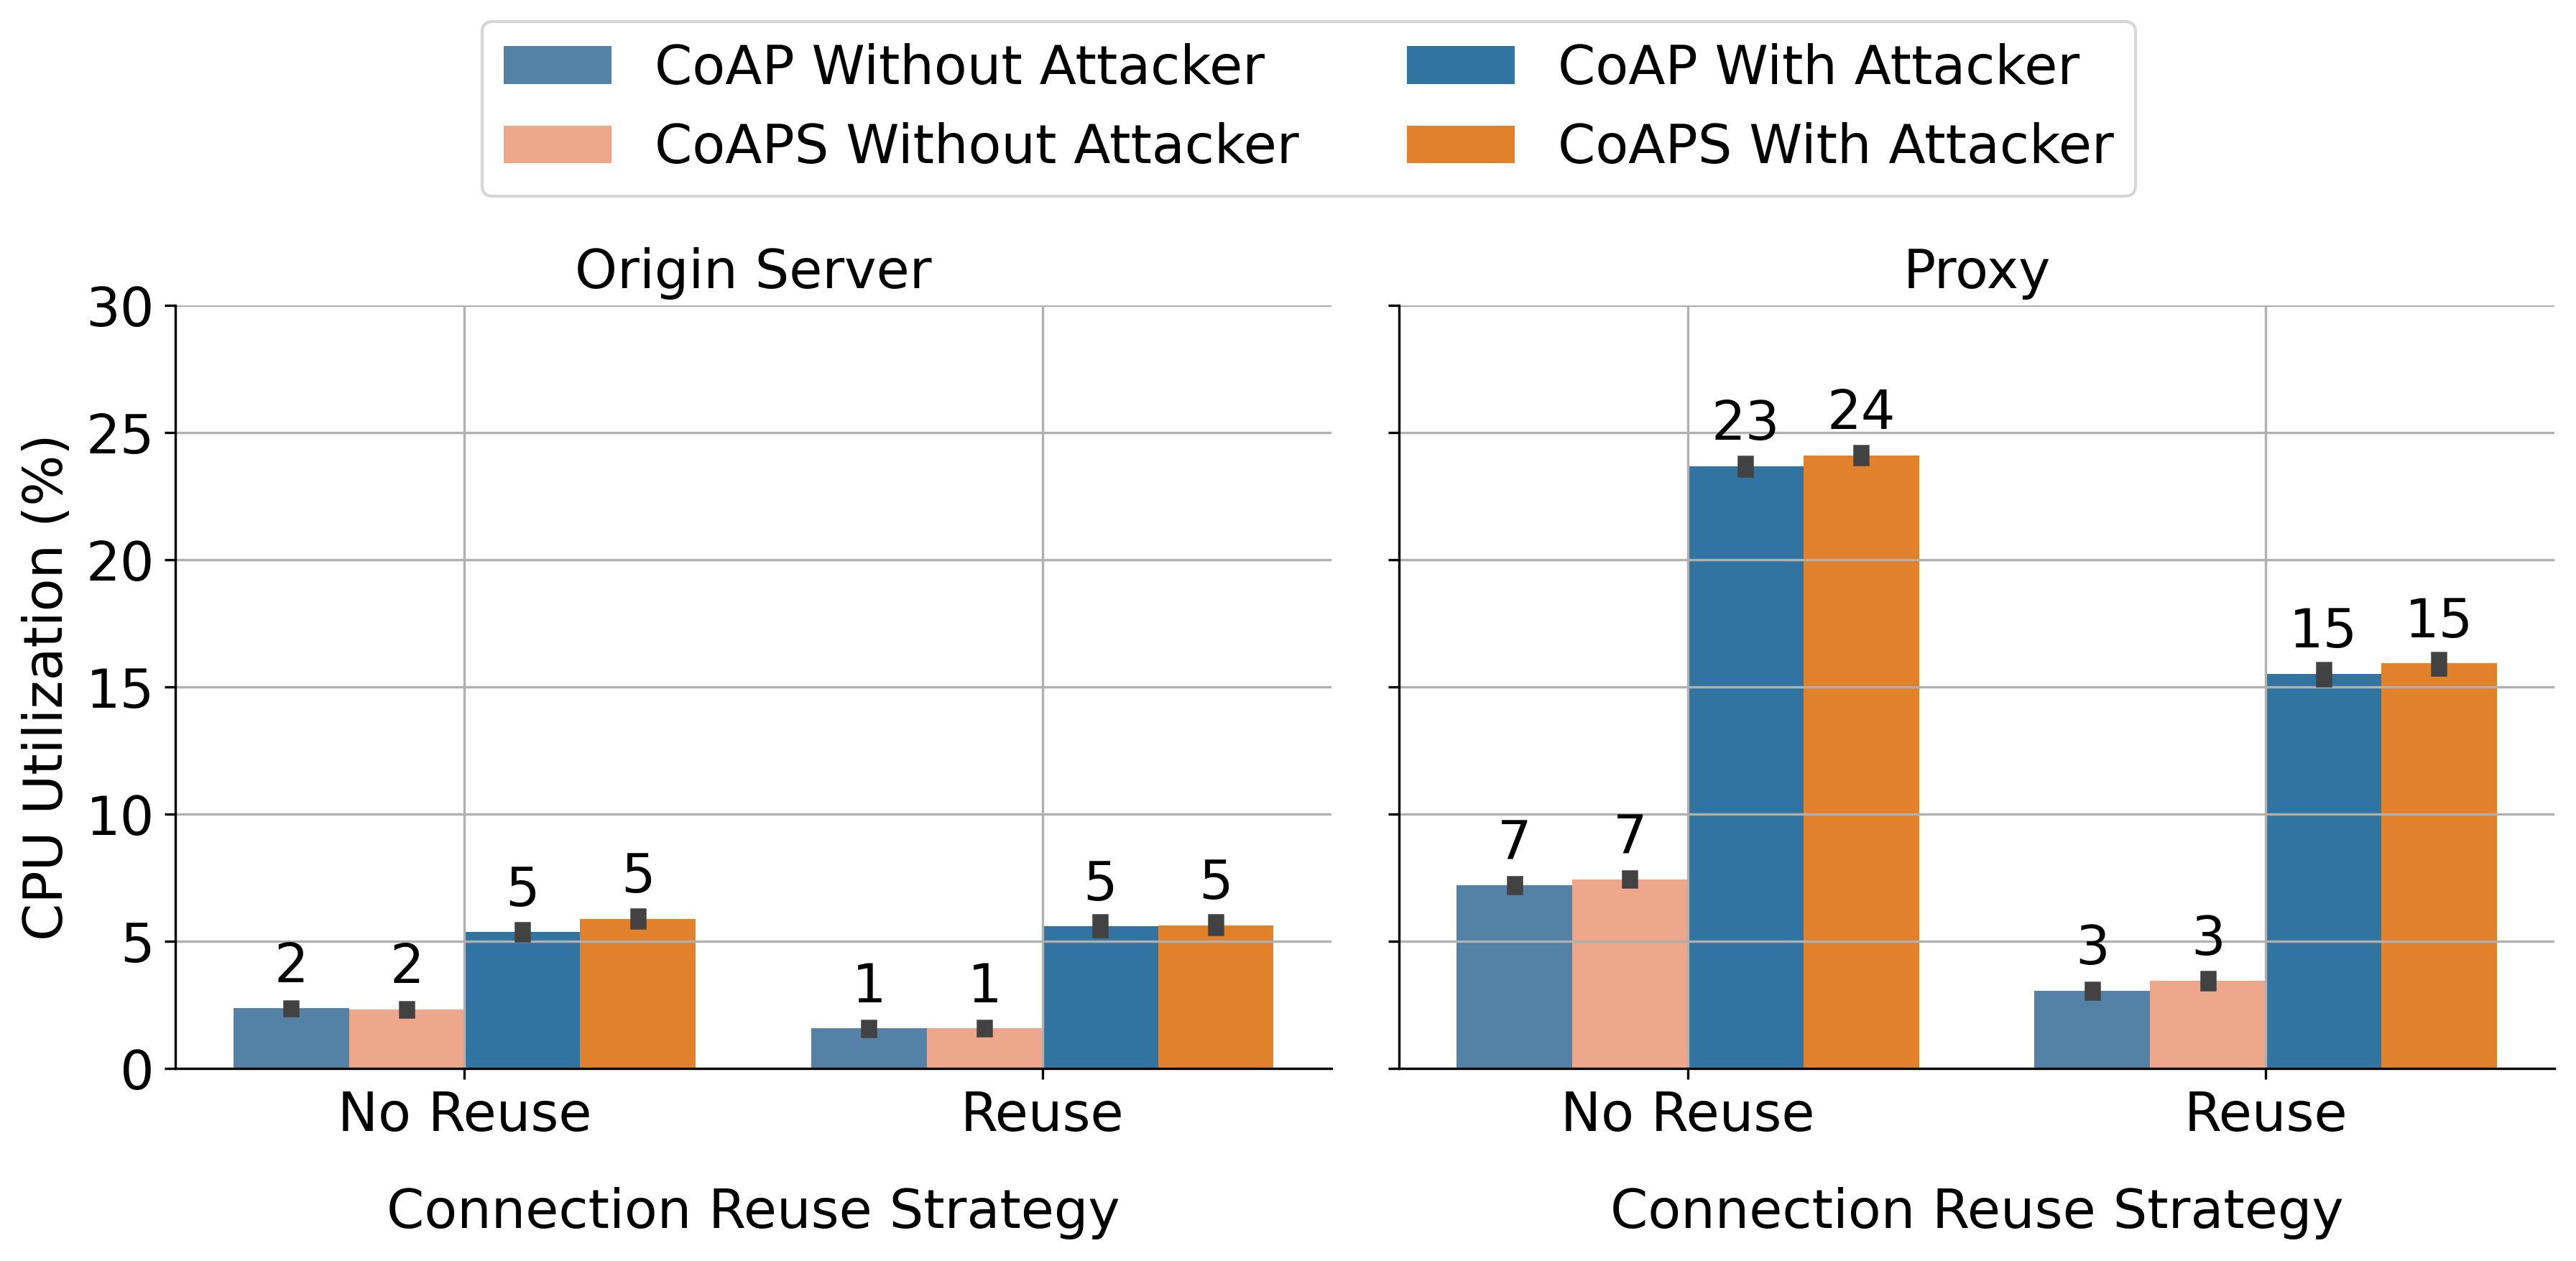

CPU times: user 1.96 s, sys: 156 ms, total: 2.12 s
Wall time: 1.81 s


exp_id  \
0     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
5     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
8     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                               ...   
149  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
152  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
153  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
156  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
157  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial    observer_id        metric_type  avg_value  min_value  max_value  \
0        1  Origin Server  % CPU Utilization   2.380000        0.4       10.8   
1        1          Proxy  % CPU Utilization   7.144286        0.5       22.1   
4        2  Origin Server  % CPU Utilization   2.401429        0.4       10.0   
5        2          Proxy  % CPU Utilization   7.141429        0.5       21.9   
8        3  Origin Server  % CPU Utilization   2.343571        0.4       10.1   
..     ...            ...                ...        ...        ...        ...   
149      3          Proxy  % CPU Utilization  15.795000        0.4       86.9   
152      4  Origin Server  % CPU Utilization   5.493571        0.5       24.8   
153      4          Proxy  % CPU Utilization  16.150714        0.5       86.0   
156      5  Origin Server  % CPU Utilization   5.586429        0.4       23.4   
157      5          Proxy  % CPU Utilization  16.064286        0.4       91.9   

    attacker_rate  server_connections  max_keep_alive_requests  ...  \
0           0mbps                 256                        0  ...   
1           0mbps                 256                        0  ...   
4           0mbps                 256                        0  ...   
5           0mbps                 256                        0  ...   
8           0mbps                 256                        0  ...   
..            ...                 ...                      ...  ...   
149       100mbps                 256                        0  ...   
152       100mbps                 256                        0  ...   
153       100mbps                 256                        0  ...   
156       100mbps                 256                        0  ...   
157       100mbps                 256                        0  ...   

     num_proxy_connections  request_timeout  max_retries  keep_alive_duration  \
0                       50                5            2                    5   
1                       50                5            2                    5   
4                       50                5            2                

In [157]:
%%time

## Measure proxy and server metrics with/out attacker.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
  .replace(value_map_replacement)
  .rename(columns={
    "run_attacker": "Attacker Presence",
    "run_proxy_with_dtls": "Client Protocol",
  })
)

df = df[df["metric_type"] == "% CPU Utilization"]
df.sort_values(
  by=["Attacker Presence", "Client Protocol"],
  ascending=[False, True],
  inplace=True,
)
df["client_attacker_combo"] = df["Client Protocol"].astype(str) + " " + df["Attacker Presence"].astype(str)

g = sns.catplot(
  data=df,
  kind="bar",
  x="reuse_connections",
  y="avg_value",
  col="observer_id",
  hue="client_attacker_combo",
  palette=sns.color_palette(["steelblue", "lightsalmon", "tab:blue", "tab:orange"]),
  facet_kws={
    "sharey": True,
    "sharex": True,
  },
  aspect=1.25,
)

g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set_xlabels("Connection Reuse Strategy", labelpad=15)

g.axes[0,0].set_ylabel("CPU Utilization (%)")
g.axes[0,1].set_ylabel("")
g.axes[0,0].grid(True, axis="both")
g.axes[0,1].grid(True, axis="both")
g.axes[0,0].set_ylim(0, 30)
g.axes[0,1].set_ylim(0, 30)

axes = [
  g.axes[0,0],
  g.axes[0,1],
]
for ax in axes:
  ax.grid(True, axis="y")
  for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=5)

sns.move_legend(
  g,
  "upper center",
  bbox_to_anchor=(0.4, 1.18),
  ncol=2,
  title=None,
  frameon=True,
)

plt.show()

df

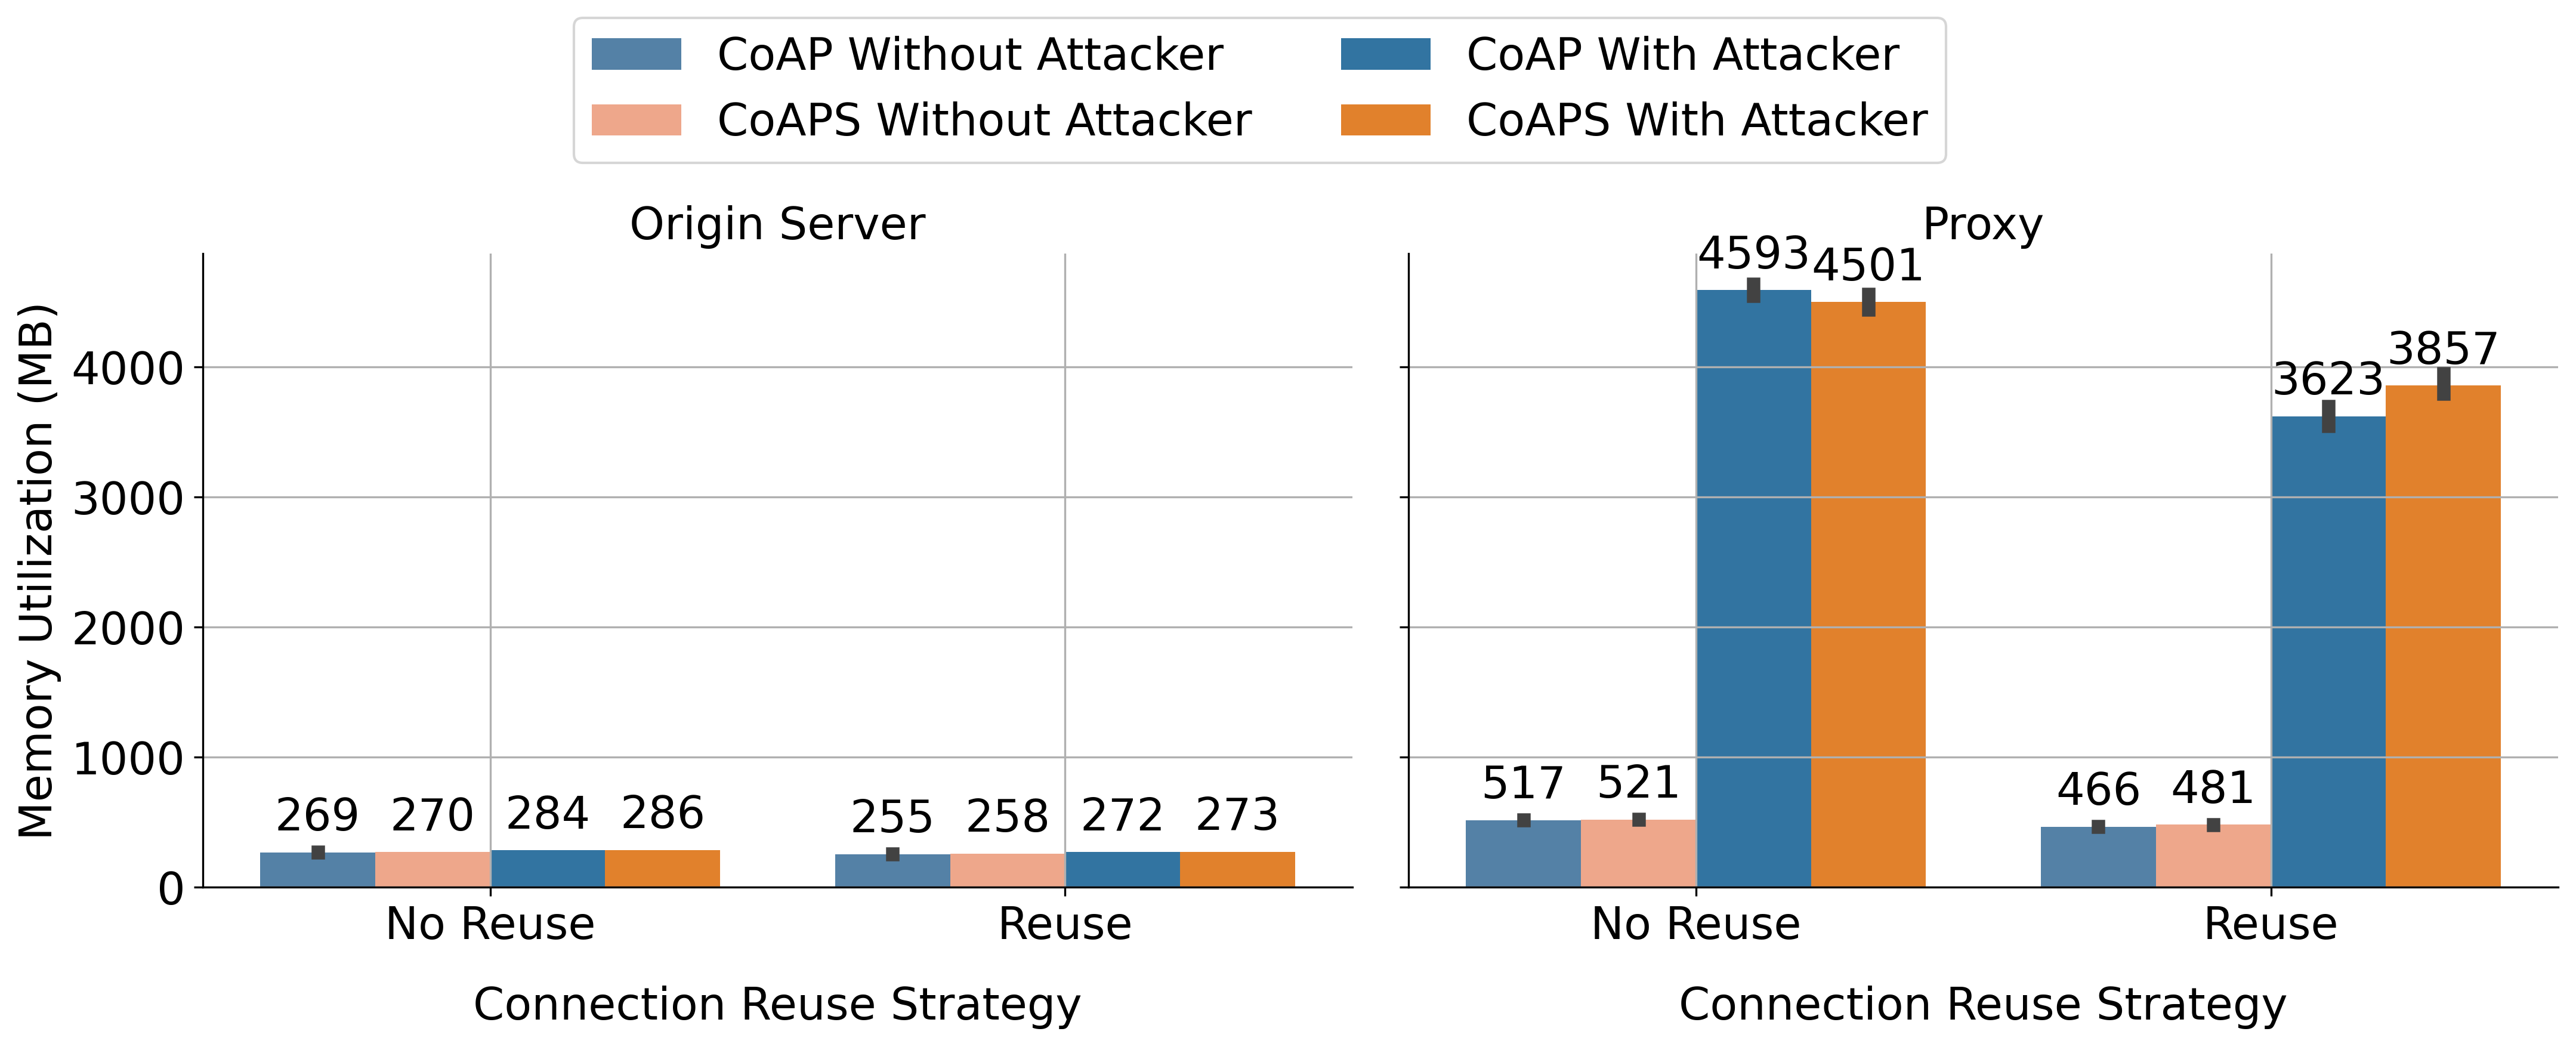

CPU times: user 1.98 s, sys: 149 ms, total: 2.13 s
Wall time: 1.82 s


exp_id  \
2     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
6     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
7     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
10    thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                               ...   
151  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
154  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
155  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
158  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
159  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial    observer_id            metric_type    avg_value  min_value  \
2        1  Origin Server  MB Memory Utilization   267.950413      245.0   
3        1          Proxy  MB Memory Utilization   515.880795      264.0   
6        2  Origin Server  MB Memory Utilization   269.489256      245.0   
7        2          Proxy  MB Memory Utilization   519.733884      265.0   
10       3  Origin Server  MB Memory Utilization   269.447934      247.0   
..     ...            ...                    ...          ...        ...   
151      3          Proxy  MB Memory Utilization  3814.594324      268.0   
154      4  Origin Server  MB Memory Utilization   273.776490      252.0   
155      4          Proxy  MB Memory Utilization  3856.508333      268.0   
158      5  Origin Server  MB Memory Utilization   274.095868      251.0   
159      5          Proxy  MB Memory Utilization  3796.620000      268.0   

     max_value attacker_rate  server_connections  max_keep_alive_requests  \
2        271.0         0mbps                 256                        0   
3        537.0         0mbps                 256                        0   
6        272.0         0mbps                 256                        0   
7        543.0         0mbps                 256                        0   
10       272.0         0mbps                 256                        0   
..         ...           ...                 ...                      ...   
151     6296.0       100mbps                 256                        0   
154      297.0       100mbps                 256                        0   
155     6450.0       100mbps                 256                        0   
158      301.0       100mbps                 256                        0   
159     6280.0       100mbps                 256                        0   

     ...  num_proxy_connections  request_timeout  max_retries  \
2    ...                     50                5            2   
3    ...                     50                5            2   
6    ...                     50                5            2   
7    ...                     50            

In [165]:
%%time

## Measure proxy and server metrics with/out attacker.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
  .replace(value_map_replacement)
  .rename(columns={
    "run_attacker": "Attacker Presence",
    "run_proxy_with_dtls": "Client Protocol",
  })
)

df = df[df["metric_type"] == "MB Memory Utilization"]
df.sort_values(
  by=["Attacker Presence", "Client Protocol"],
  ascending=[False, True],
  inplace=True,
)
df["client_attacker_combo"] = df["Client Protocol"].astype(str) + " " + df["Attacker Presence"].astype(str)

g = sns.catplot(
  data=df,
  kind="bar",
  x="reuse_connections",
  y="avg_value",
  col="observer_id",
  hue="client_attacker_combo",
  palette=sns.color_palette(["steelblue", "lightsalmon", "tab:blue", "tab:orange"]),
  facet_kws={
    "sharey": True,
    "sharex": True,
  },
  aspect=1.50,
)

g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set_xlabels("Connection Reuse Strategy", labelpad=15)

g.axes[0,0].set_ylabel("Memory Utilization (MB)")
g.axes[0,1].set_ylabel("")
g.axes[0,0].grid(True, axis="both")
g.axes[0,1].grid(True, axis="both")
# g.axes[0,0].set_ylim(0, 30)
# g.axes[0,1].set_ylim(0, 30)

axes = [
  g.axes[0,0],
  g.axes[0,1],
]
for ax in axes:
  ax.grid(True, axis="y")
  for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=5, fontsize="medium")

sns.move_legend(
  g,
  "upper center",
  bbox_to_anchor=(0.4, 1.18),
  ncol=2,
  title=None,
  frameon=True,
)

plt.show()

df

In [53]:
_df = (
  df
  .groupby(
    by=["reuse_connections", "Attacker Presence", "Client Protocol", "observer_id", "metric_type"]
  )
  .agg(
    mean_metric_value=("avg_value", "mean")
  )
  .reset_index()
)

(
  _df
  [
    (_df["observer_id"] != "Origin Server")
    & (_df["metric_type"] != "% CPU Utilization")
  ]
  .sort_values(by=[
    "reuse_connections", "Attacker Presence", "Client Protocol", "observer_id", "metric_type",
  ])
)

reuse_connections Attacker Presence Client Protocol observer_id  \
3   No Connection Reuse     With Attacker            CoAP       Proxy   
7   No Connection Reuse     With Attacker           CoAPS       Proxy   
11  No Connection Reuse  Without Attacker            CoAP       Proxy   
15  No Connection Reuse  Without Attacker           CoAPS       Proxy   
19    Reuse Connections     With Attacker            CoAP       Proxy   
23    Reuse Connections     With Attacker           CoAPS       Proxy   
27    Reuse Connections  Without Attacker            CoAP       Proxy   
31    Reuse Connections  Without Attacker           CoAPS       Proxy   

              metric_type  mean_metric_value  
3   MB Memory Utilization        4593.218002  
7   MB Memory Utilization        4501.553256  
11  MB Memory Utilization         517.114010  
15  MB Memory Utilization         521.451901  
19  MB Memory Utilization        3623.390420  
23  MB Memory Utilization        3857.883531  
27  MB Memory Utilization         466.366281  
31  MB Memory Utilization         481.851570

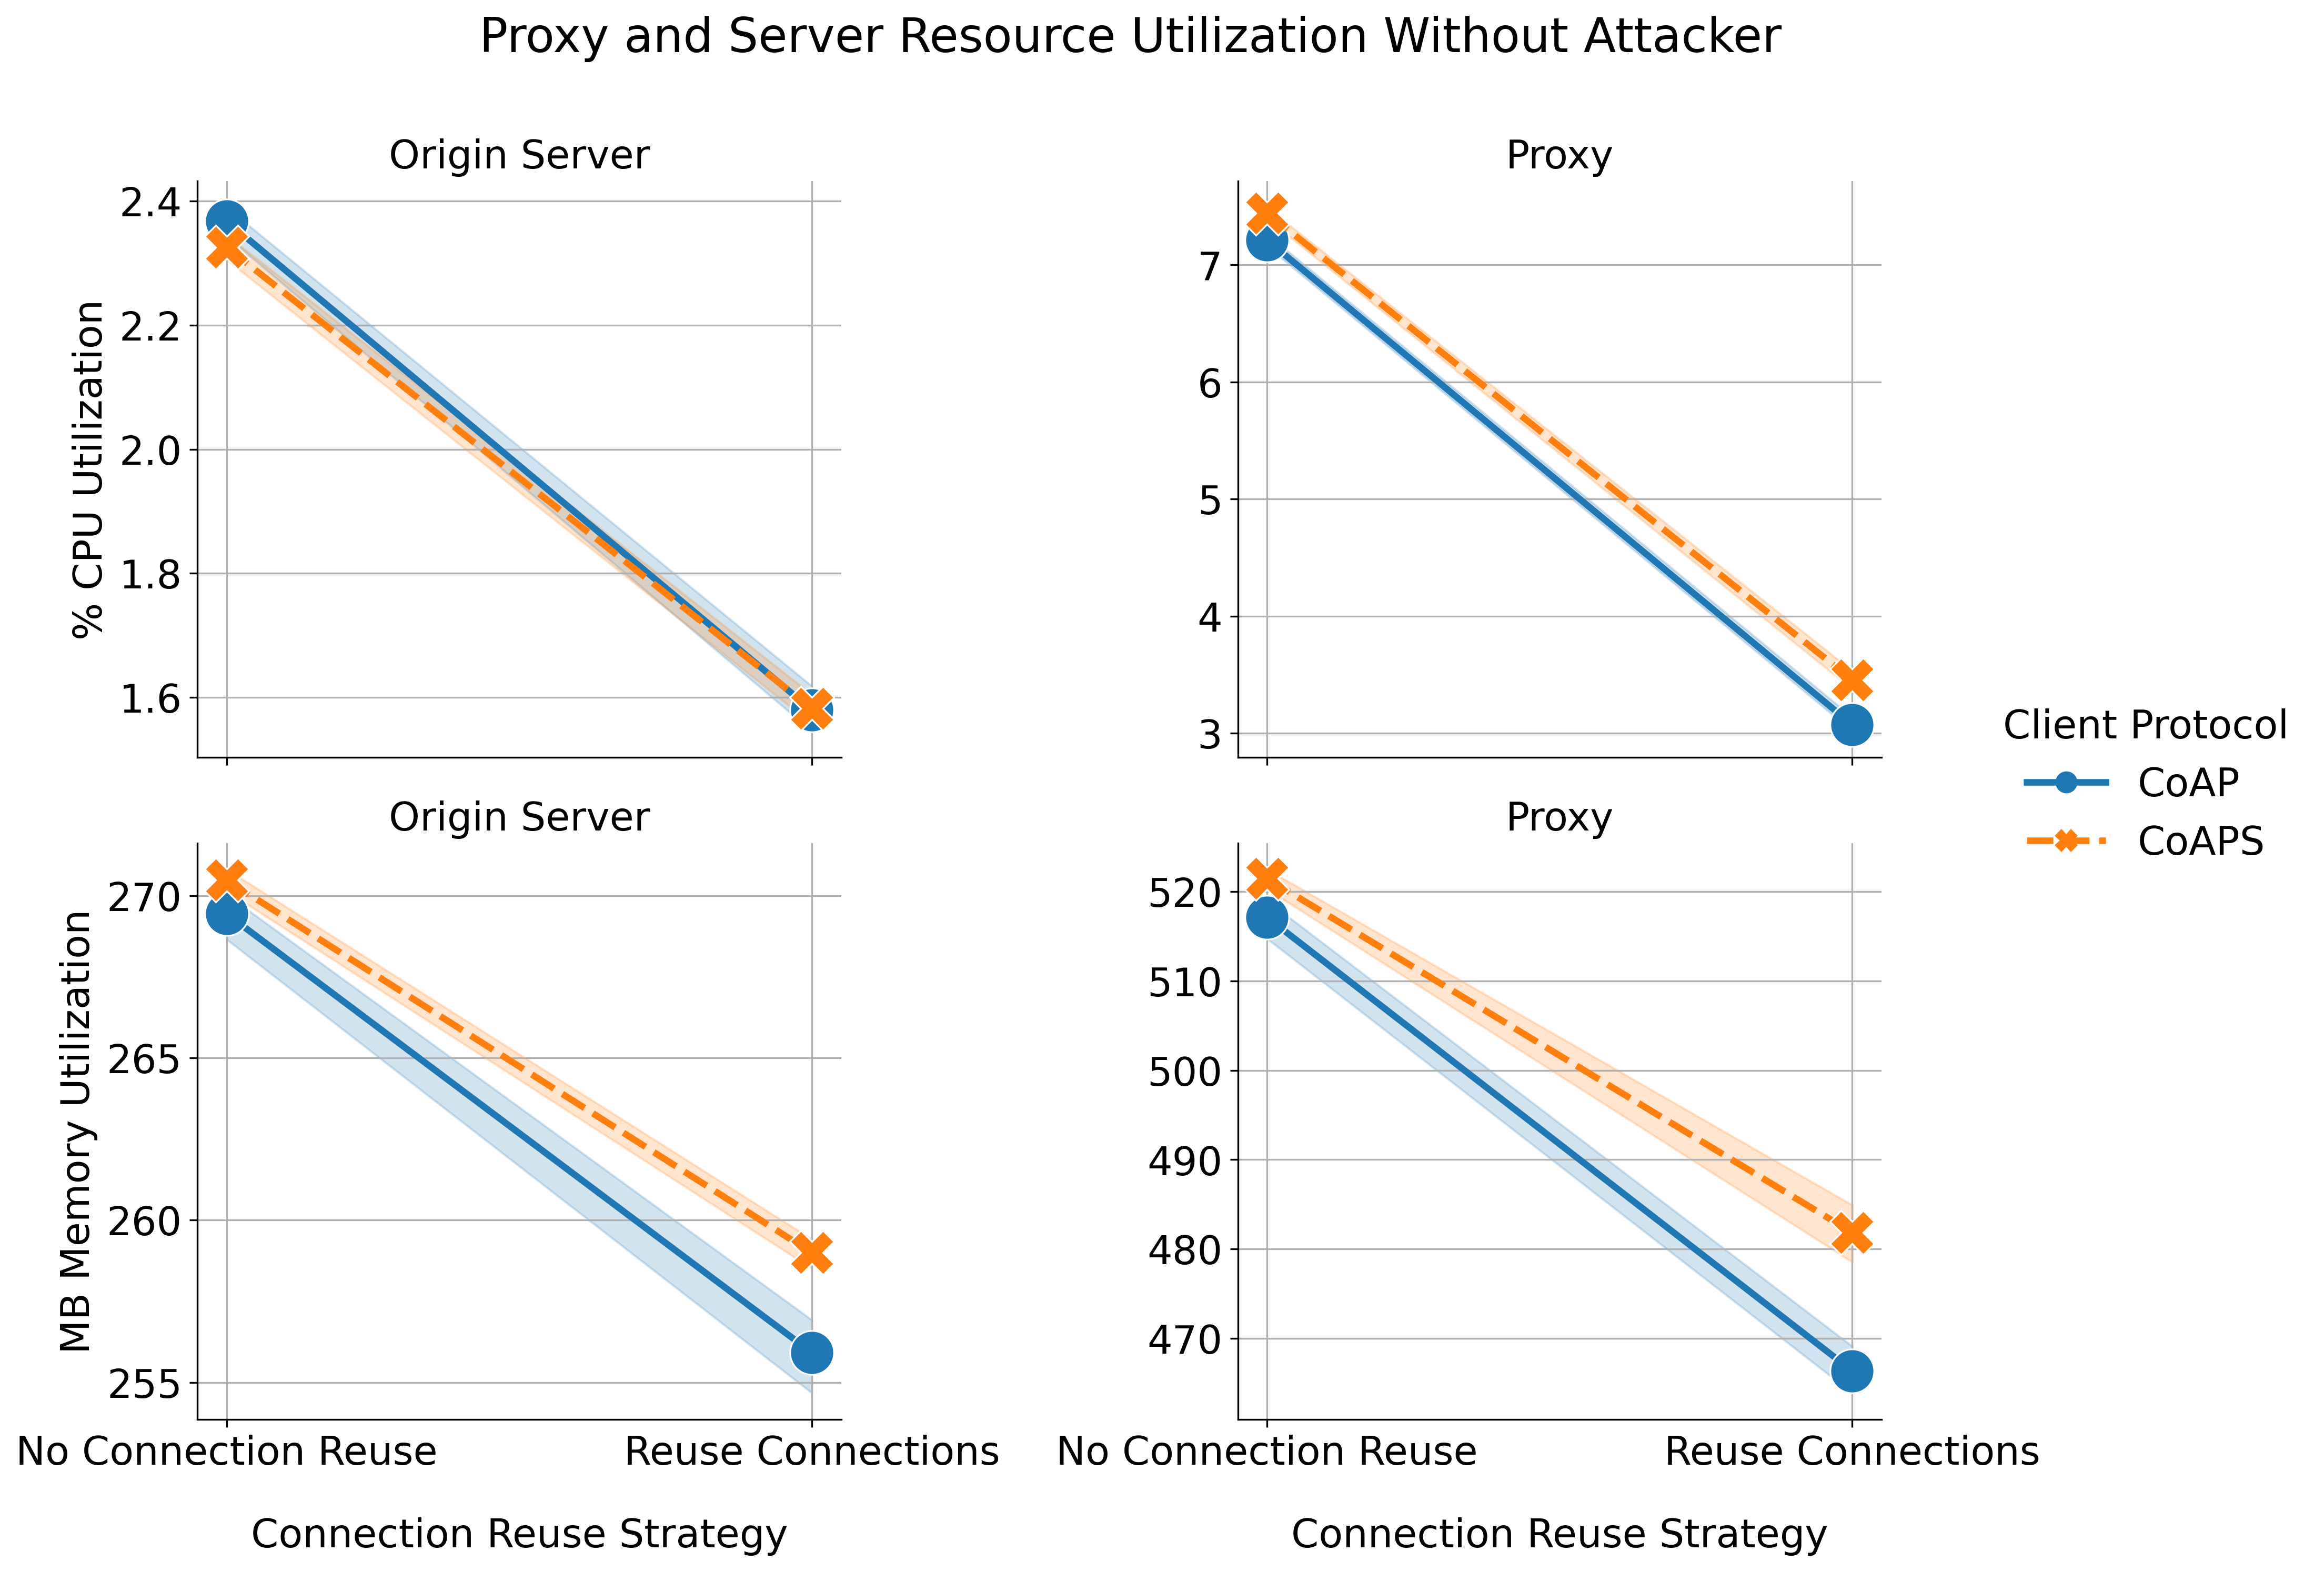

CPU times: user 2.92 s, sys: 239 ms, total: 3.16 s
Wall time: 2.86 s


exp_id  \
0     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4     thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                               ...   
155  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
156  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
157  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
158  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
159  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial    observer_id            metric_type    avg_value  min_value  \
0        1  Origin Server      % CPU Utilization     2.380000        0.4   
1        1          Proxy      % CPU Utilization     7.144286        0.5   
2        1  Origin Server  MB Memory Utilization   267.950413      245.0   
3        1          Proxy  MB Memory Utilization   515.880795      264.0   
4        2  Origin Server      % CPU Utilization     2.401429        0.4   
..     ...            ...                    ...          ...        ...   
155      4          Proxy  MB Memory Utilization  3856.508333      268.0   
156      5  Origin Server      % CPU Utilization     5.586429        0.4   
157      5          Proxy      % CPU Utilization    16.064286        0.4   
158      5  Origin Server  MB Memory Utilization   274.095868      251.0   
159      5          Proxy  MB Memory Utilization  3796.620000      268.0   

     max_value attacker_rate  server_connections  max_keep_alive_requests  \
0         10.8         0mbps                 256                        0   
1         22.1         0mbps                 256                        0   
2        271.0         0mbps                 256                        0   
3        537.0         0mbps                 256                        0   
4         10.0         0mbps                 256                        0   
..         ...           ...                 ...                      ...   
155     6450.0       100mbps                 256                        0   
156       23.4       100mbps                 256                        0   
157       91.9       100mbps                 256                        0   
158      301.0       100mbps                 256                        0   
159     6280.0       100mbps                 256                        0   

     ...                             topology_name  num_proxy_connections  \
0    ...  thesis_cloud_proxy_and_internet_attacker                     50   
1    ...  thesis_cloud_proxy_and_internet_attacker                     50   
2    ...  thesis_cloud_proxy_and_internet_attacker                     5

In [54]:
%%time

## Measure proxy and server metrics without attacker.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
  .replace(value_map_replacement)
)

g = sns.relplot(
  data=df[df["run_attacker"] == "Without Attacker"],
  kind="line",
  x="reuse_connections",
  y="avg_value",
  col="observer_id",
  row="metric_type",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=20,
  facet_kws={
    "sharey": False,
    "sharex": True,
  },
  aspect=1.25,
)

g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.legend.set_title("Client Protocol")
g.set_xlabels("Connection Reuse Strategy", labelpad=20)
g.set_ylabels("Average Metric Value")

g.axes[0,0].set_ylabel("% CPU Utilization")
g.axes[0,1].set_ylabel("")
# g.axes[0,0].set_ylim(0,25)
# g.axes[0,1].set_ylim(0,25)

g.axes[1,0].set_ylabel("MB Memory Utilization")
g.axes[1,1].set_ylabel("")

g.axes[0,0].grid(True, axis="both")
g.axes[0,1].grid(True, axis="both")
g.axes[1,0].grid(True, axis="both")
g.axes[1,1].grid(True, axis="both")

g.fig.suptitle("Proxy and Server Resource Utilization Without Attacker")
g.fig.subplots_adjust(top=0.875)

plt.show()

df

In [55]:
%%time

## Measure proxy and server connection management.
##
## We currently do not insert connection events to
## the database, so we have to read from the processed
## connection files.

ALL_EXPERIMENTS_DATA_HOME = "/home/ubuntu/dos-californium/deter/expdata/real/final"

def read_exp_trial_node_connections(exp_id):
  """
  Read all processed connection dumps in an experiment `exp_id`.
  """
  experiment_dir = os.path.join(ALL_EXPERIMENTS_DATA_HOME, exp_id)

  df = (
    pl
    .scan_parquet(
      f"{experiment_dir}/*/{exp_id}.connections.parquet"
    )
  )
  lazy_dfs.append(df)

lazy_dfs = list()
for exp_id in exp_df["exp_id"].unique():
  read_exp_trial_node_connections(exp_id)

connections_df = (
  pl
  .concat(lazy_dfs)

  # Filter for proxy's view of syn-acks or fin-acks coming from server
  .filter(
    (pl.col("observer_id") == "proxy")
    & ((pl.col("is_syn") == 1) | (pl.col("is_fin") == 1))
    & (pl.col("info").str.contains(", ACK]"))
    & (pl.col("src_port") == 443)
  )
  # Group by experiment, trial, and observer, then accummulate
  # syn-acks and fin-acks in a list, along with their corresponding
  # timestamps of occurrence for each group.
  .groupby(
    by=["exp_id", "trial", "observer_id"],
    maintain_order=True
  )
  .agg([
    pl.col("timestamp").alias("timestamp"),
    pl.col("is_syn").cumsum().alias("cum_syn"),
    pl.col("is_fin").cumsum().alias("cum_fin"),
  ])
  # Explode the cumulative syns and fins, and their times, then
  # subtract them to get a view of how many open connections there
  # are in the experiment as a function of time
  .explode(columns=["timestamp", "cum_syn", "cum_fin"])
  .with_columns([
    (pl.col("cum_syn") - pl.col("cum_fin")).alias("open_connections")
  ])

  # And finally convert to pandas for plotting.
  .collect()
  .to_pandas()
)

# This method of counting does not include the original 0 connections
# at time 0 for each node in each trial -- so we add that manually.
records = list()
for e in connections_df["exp_id"].unique():
  for t in connections_df["trial"].unique():
    for o in connections_df["observer_id"].unique():
      records.append({
        "exp_id"          : e,
        "trial"           : t,
        "observer_id"     : o,
        "timestamp"       : 0.0,
        "cum_syn"         : 0,
        "cum_fin"         : 0,
        "open_connections": 0,
      })
connections_df = (
  pd.concat(
    [connections_df, pd.DataFrame.from_records(records)]
  )
  .sort_values(by=["exp_id", "trial", "observer_id", "timestamp"])
)

# This method also does not include a connection count at the last time
# the proxy is meant to be active -- so we fill that value in based on the
# last value.
last_connection_df = (
  connections_df
  .groupby(by=["exp_id", "trial", "observer_id"], sort=True)
  .agg(
    max_timestamp=("timestamp", "max"),
    last_timestamp=("timestamp", "last"),
    max_open_connections=("open_connections", "max"),
    last_open_connections=("open_connections", "last"),
    last_cum_syn=("cum_syn", "last"),
    last_cum_fin=("cum_fin", "last"),
  )
  .reset_index()
)
# assert last_connection_df["max_timestamp"].equals(last_connection_df["last_timestamp"])
# assert last_connection_df["max_open_connections"].equals(last_connection_df["last_open_connections"])
records = list()
for r in last_connection_df.to_dict(orient="records"):
  records.append({
    "exp_id"          : r["exp_id"],
    "trial"           : r["trial"],
    "observer_id"     : r["observer_id"],
    "timestamp"       : 140,
    "cum_syn"         : r["last_cum_syn"],
    "cum_fin"         : r["last_cum_fin"],
    "open_connections": r["last_open_connections"],
  })
connections_df = (
  pd.concat(
    [connections_df, pd.DataFrame.from_records(records)]
  )
  .sort_values(by=["exp_id", "trial", "observer_id", "timestamp"])
)

connections_df = (
  connections_df
  .merge(exp_df, on="exp_id", how="left")
  .replace(value_map_replacement)
)

connections_df

CPU times: user 1min 13s, sys: 2min 19s, total: 3min 33s
Wall time: 18.1 s


exp_id  \
0        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                                 ...   
528671  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
528672  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
528673  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
528674  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
528675  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

        trial observer_id   timestamp  cum_syn  cum_fin  open_connections  \
0           1       proxy    0.000000        0        0                 0   
1           1       proxy    0.066038        1        0                 1   
2           1       proxy    0.356691        2        0                 2   
3           1       proxy    0.453487        3        0                 3   
4           1       proxy    0.545456        4        0                 4   
...       ...         ...         ...      ...      ...               ...   
528671      5       proxy  128.289726       52       49                 3   
528672      5       proxy  128.719208       52       50                 2   
528673      5       proxy  130.221829       52       51                 1   
528674      5       proxy  131.295056       52       52                 0   
528675      5       proxy  140.000000       52       52                 0   

       attacker_rate  server_connections  max_keep_alive_requests  ...  \
0              0mbps                 256                        0  ...   
1              0mbps                 256                        0  ...   
2              0mbps                 256                        0  ...   
3              0mbps                 256                        0  ...   
4              0mbps                 256                        0  ...   
...              ...                 ...                      ...  ...   
528671       100mbps                 256                        0  ...   
528672       100mbps                 256                        0  ...   
528673       100mbps                 256                        0  ...   
528674       100mbps                 256                        0  ...   
528675       100mbps                 256                        0  ...   

                                   topology_name  num_proxy_connections  \
0       thesis_cloud_proxy_and_internet_attacker                     50   
1       thesis_cloud_proxy_and_internet_attacker                     50   
2       thesis_cloud_proxy_and_internet_attacker                     

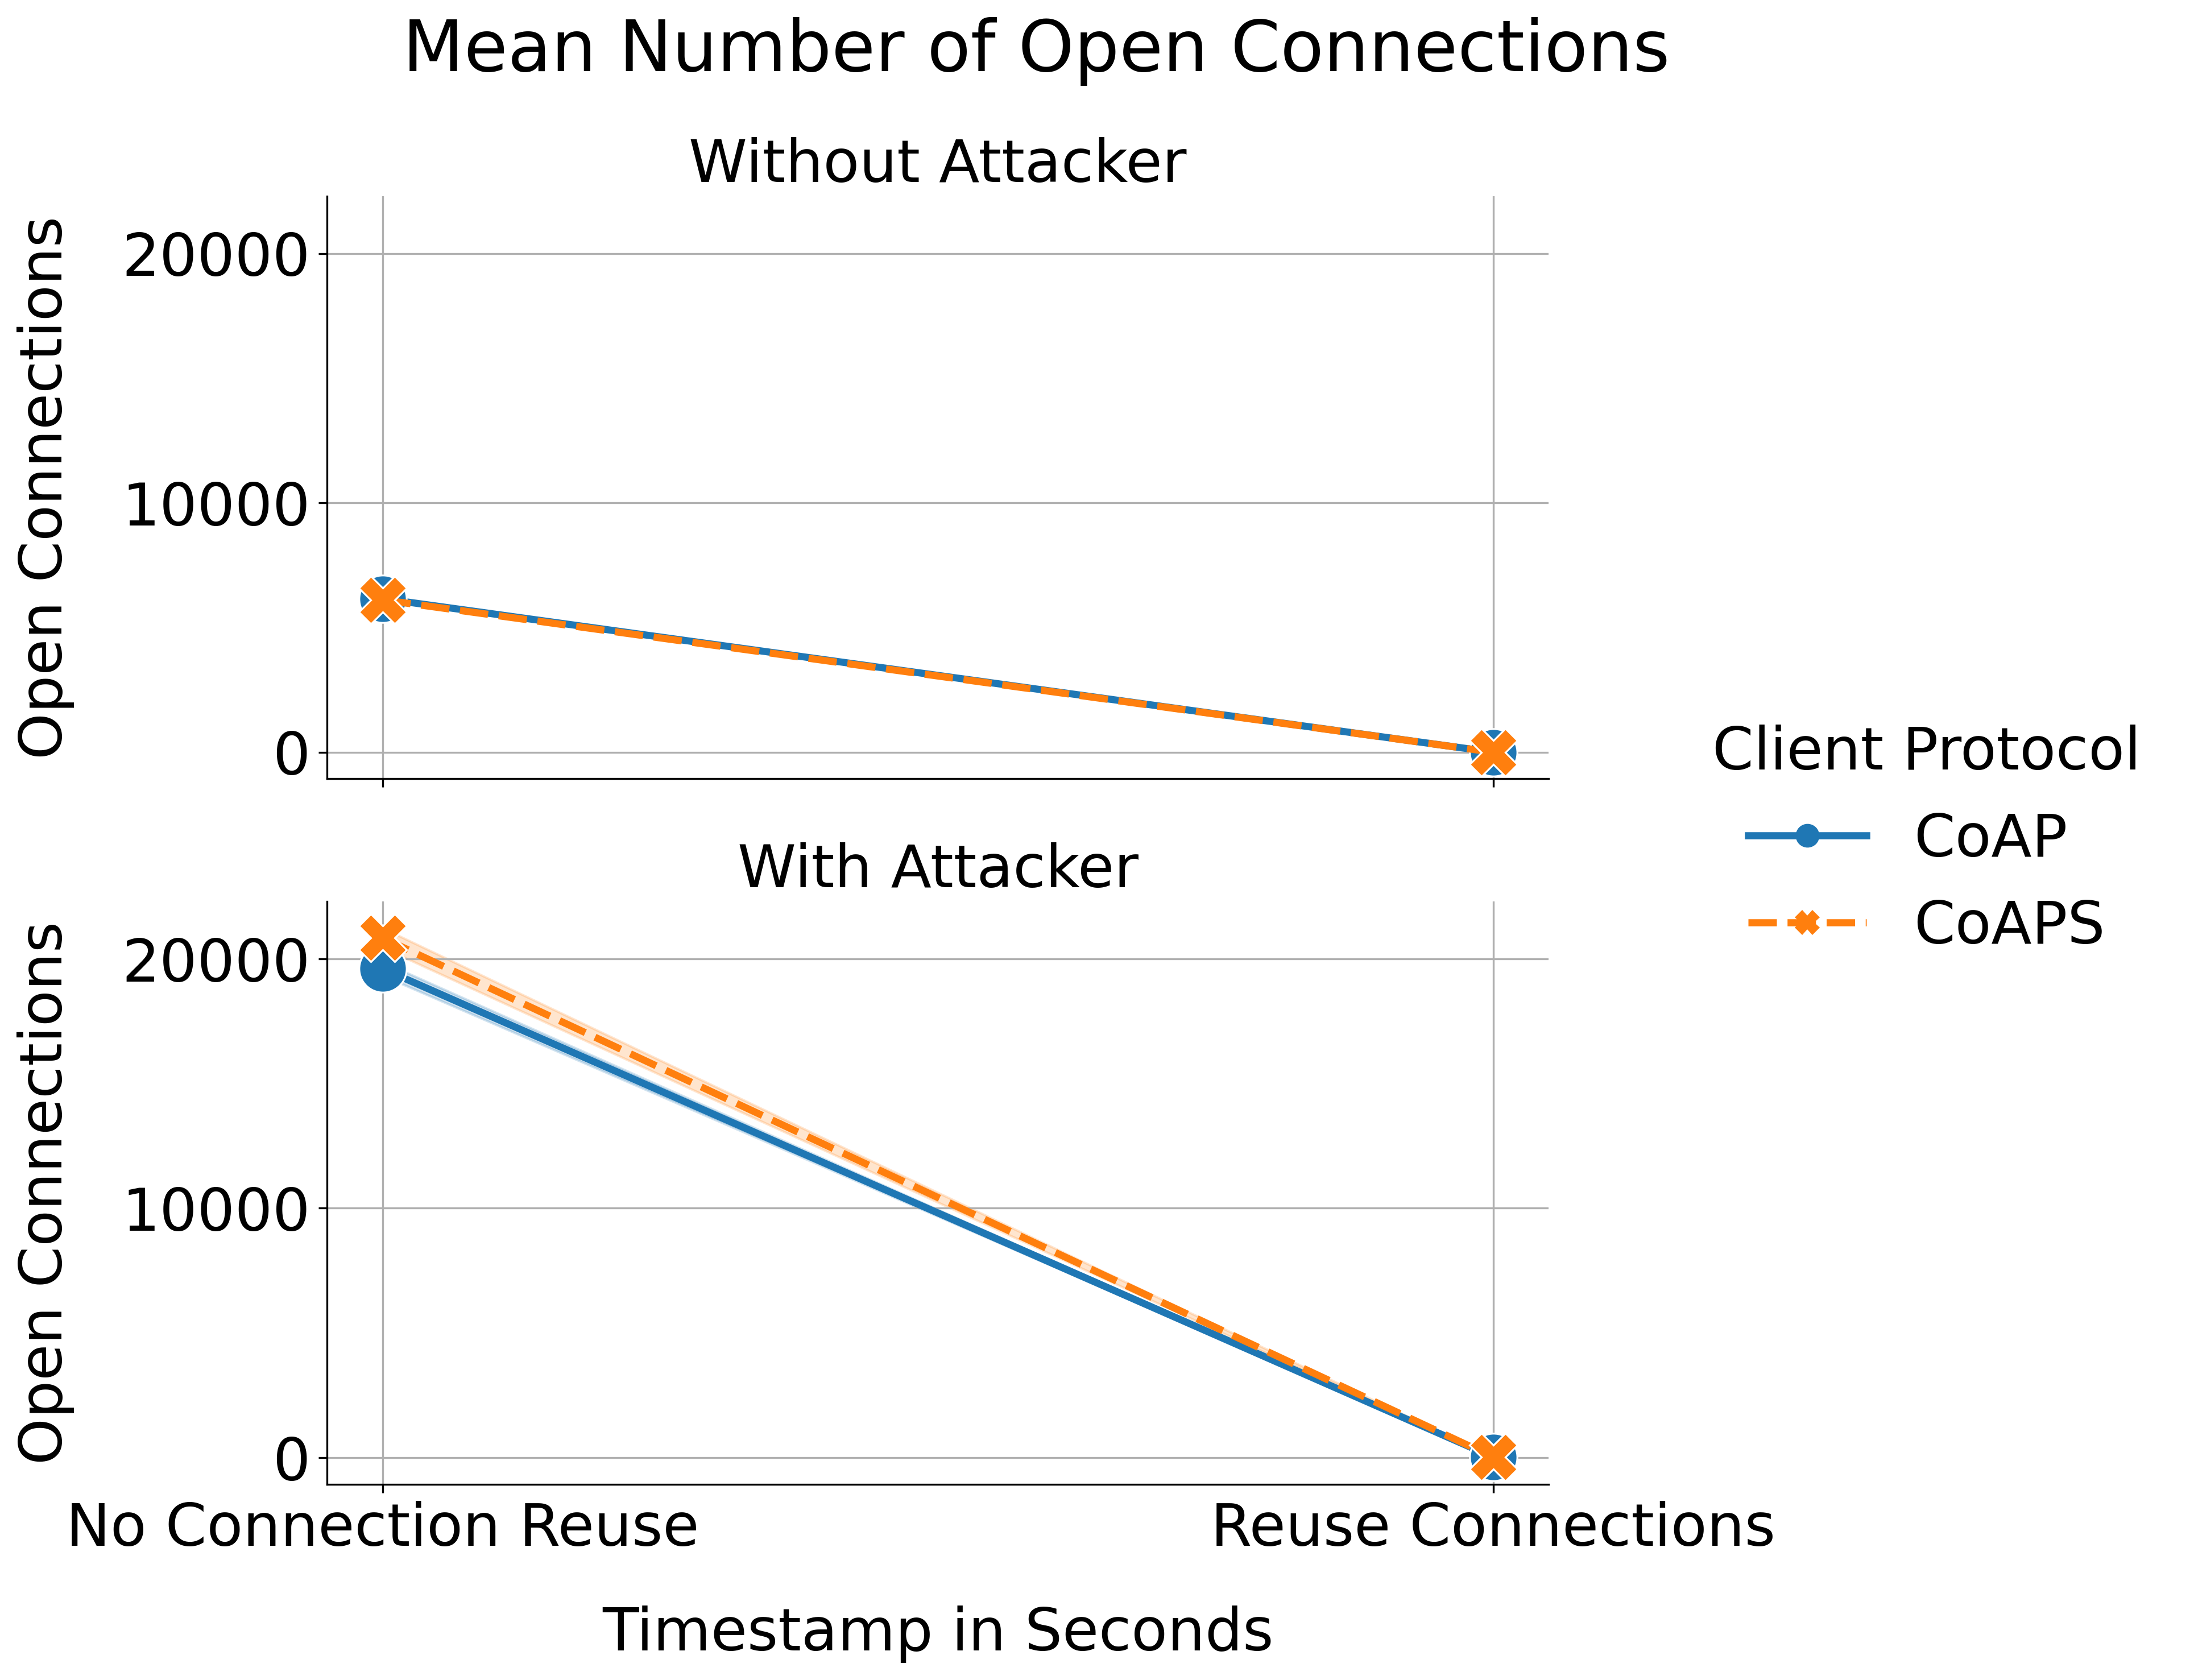

CPU times: user 2.15 s, sys: 162 ms, total: 2.31 s
Wall time: 2.01 s


In [56]:
%%time

## Measure proxy and server connection management.

# Here, we need to do an average over the number of
# connections, since when we don't reuse connections,
# a new one keeps getting opened.
df = (
  connections_df
  .groupby(by=["exp_id", "trial", "observer_id", "run_proxy_with_dtls", "run_attacker", "reuse_connections"])
  .agg(
    mean_open_connections=("open_connections", "mean"),
  )
  .reset_index()
)

plt.rcParams['font.size'] = '25'

g = sns.relplot(
  data=df,
  kind="line",
  x="reuse_connections",
  # x="timestamp",
  y="mean_open_connections",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  col="run_attacker",
  col_wrap=1,
  markers=True,
  markersize=20,
  facet_kws={
    "sharey": True,
    "sharex": True,
  },
  aspect=2,
)
g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set_xlabels("Timestamp in Seconds", labelpad=20)
g.set_ylabels("Open Connections", labelpad=20)
g.legend.set_title("Client Protocol")
for i in range(2):
  g.axes[i].grid(True, axis="both")

g.fig.suptitle("Mean Number of Open Connections")
g.fig.subplots_adjust(top=0.875)

plt.show()

In [57]:
%%time

communication_pattern_rates_sql = f"""
WITH all_patterns AS (
  SELECT
    dn.exp_id AS exp_id,
    e.trial AS trial,
    e.observe_timestamp AS observe_timestamp,
    floor(e.observe_timestamp) AS timestamp_bin,
    e.message_marker AS message_marker,
    concat(node_src.node_name, '->', node_dst.node_name) AS communication_pattern,
    m.size_bytes AS size_bytes
  FROM
    event e
    JOIN deployed_node dn ON dn.dnid = e.observer_id
    JOIN message m ON m.message_id = e.message_id
    JOIN node node_src ON node_src.node_id = m.src_id
    JOIN node node_dst ON node_dst.node_id = m.dst_id

), pattern_aggregations AS (
  SELECT
    exp_id,
    trial,
    communication_pattern,
    timestamp_bin,
    SUM(size_bytes) AS sum_bytes,
    COUNT(DISTINCT message_marker) AS num_messages
  FROM
    all_patterns
  GROUP BY
    exp_id, trial, communication_pattern, timestamp_bin
)

SELECT
  *,
  (1e-6 * sum_bytes) AS megabytes_per_second,
  (8 * 1e-6 * sum_bytes) AS megabits_per_second
FROM
  pattern_aggregations
ORDER BY
  timestamp_bin
"""

binned_messages_df = client.query_dataframe(communication_pattern_rates_sql)
binned_messages_df

CPU times: user 242 ms, sys: 48.4 ms, total: 290 ms
Wall time: 18.8 s


exp_id  \
0      thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1        thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2      thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
3      thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
4      thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                                 ...   
79841   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
79842   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
79843    thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
79844  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
79845  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   

       trial communication_pattern  timestamp_bin  sum_bytes  num_messages  \
0          4        proxy->client1            0.0       3120             8   
1          4        client1->proxy            0.0       1696             8   
2          1        client1->proxy            0.0       2592             9   
3          5   originserver->proxy            0.0       4419             9   
4          5        proxy->client2            0.0        195             1   
...      ...                   ...            ...        ...           ...   
79841      1        proxy->client8          126.0       1170             6   
79842      2        client8->proxy          126.0       2289            14   
79843      3   proxy->originserver          126.0       1165             5   
79844      4   originserver->proxy          126.0       2455             5   
79845      4   proxy->originserver          126.0       1165             5   

       megabytes_per_second  megabits_per_second  
0                  0.003120             0.024960  
1                  0.001696             0.013568  
2                  0.002592             0.020736  
3                  0.004419             0.035352  
4                  0.000195             0.001560  
...                     ...                  ...  
79841              0.001170             0.009360  
79842              0.002289             0.018312  
79843              0.001165             0.009320  
79844              0.002455             0.019640  
79845              0.001165             0.009320  

[79846 rows x 8 columns]

In [58]:
%%time

df = (
  binned_messages_df
  .melt(
    id_vars=["exp_id", "trial", "communication_pattern", "timestamp_bin", "sum_bytes"],
    value_vars=["megabits_per_second", "num_messages"],
    var_name="egress_rate_name",
    value_name="egress_rate_value",
  )
  .merge(exp_df, on="exp_id", how="left")
  .replace(value_map_replacement)
)

df

CPU times: user 219 ms, sys: 12.9 ms, total: 232 ms
Wall time: 229 ms


exp_id  \
0       thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1         thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2       thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
3       thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
4       thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                                  ...   
159687   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
159688   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
159689    thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
159690  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
159691  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   

        trial communication_pattern  timestamp_bin  sum_bytes  \
0           4        proxy->client1            0.0       3120   
1           4        client1->proxy            0.0       1696   
2           1        client1->proxy            0.0       2592   
3           5   originserver->proxy            0.0       4419   
4           5        proxy->client2            0.0        195   
...       ...                   ...            ...        ...   
159687      1        proxy->client8          126.0       1170   
159688      2        client8->proxy          126.0       2289   
159689      3   proxy->originserver          126.0       1165   
159690      4   originserver->proxy          126.0       2455   
159691      4   proxy->originserver          126.0       1165   

           egress_rate_name  egress_rate_value attacker_rate  \
0       megabits_per_second           0.024960       100mbps   
1       megabits_per_second           0.013568         0mbps   
2       megabits_per_second           0.020736       100mbps   
3       megabits_per_second           0.035352       100mbps   
4       megabits_per_second           0.001560       100mbps   
...                     ...                ...           ...   
159687         num_messages           6.000000       100mbps   
159688         num_messages          14.000000       100mbps   
159689         num_messages           5.000000         0mbps   
159690         num_messages           5.000000       100mbps   
159691         num_messages           5.000000       100mbps   

        server_connections  max_keep_alive_requests  ...  \
0                      256                        0  ...   
1                      256                        0  ...   
2                      256                        0  ...   
3                      256                        0  ...   
4                      256                        0  ...   
...                    ...                      ...  ...   
159687                 256                        0  ...   
159688                 256                        0  ...   
159689 

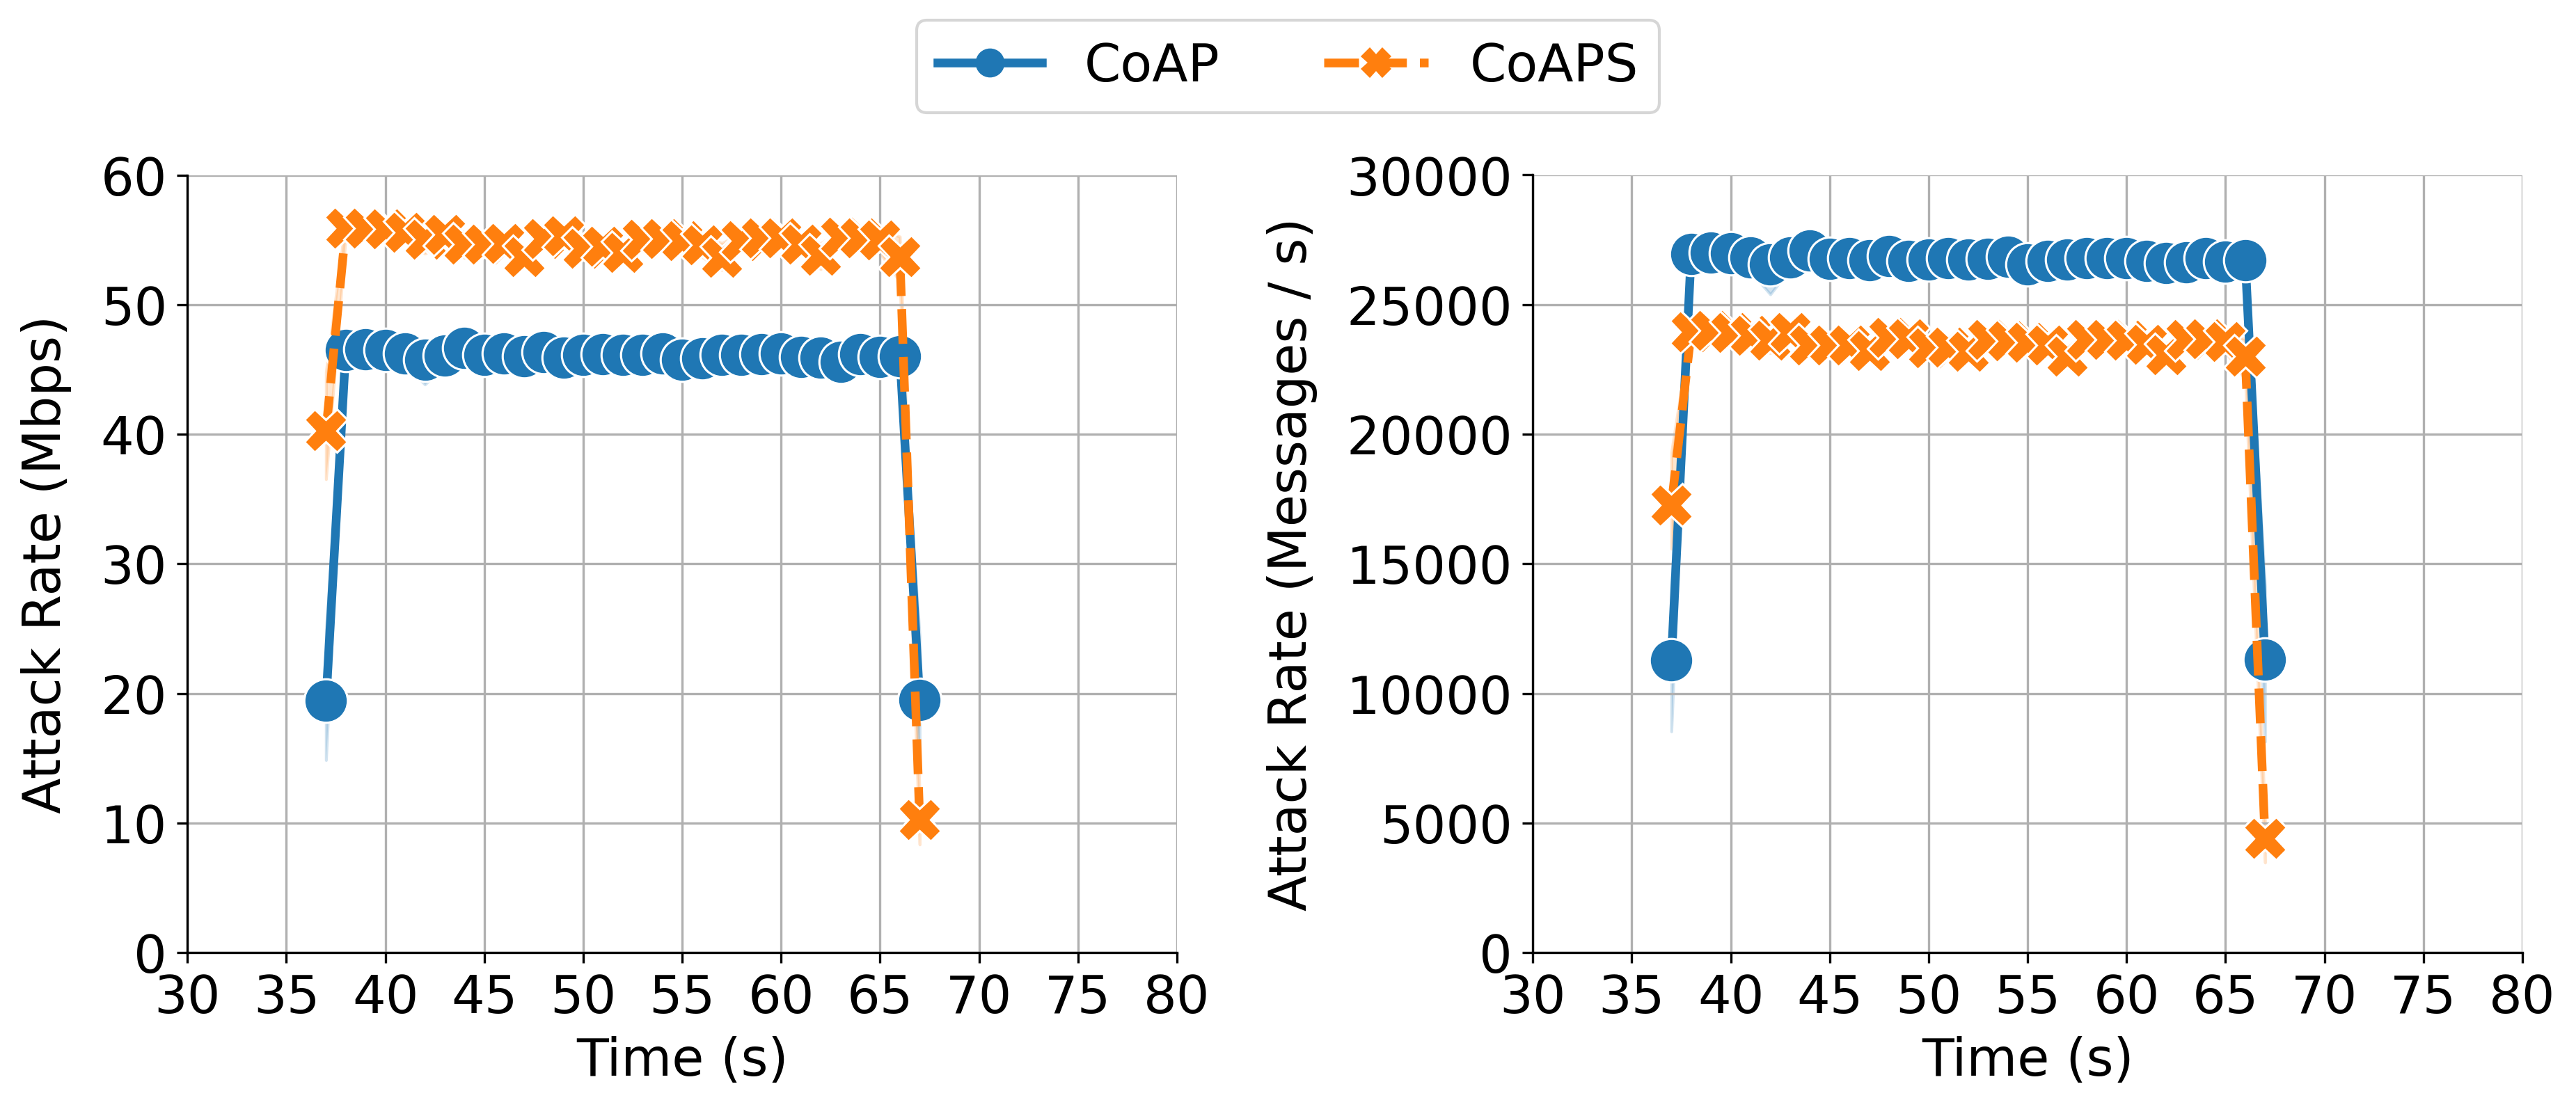

CPU times: user 5.18 s, sys: 314 ms, total: 5.5 s
Wall time: 4.95 s


exp_id  \
0  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1  thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_noconnreuse_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
2   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3   thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

  communication_pattern  avg_num_messages  avg_message_size  \
0       attacker->proxy           3997707        215.410559   
1       attacker->proxy           3548347        291.367676   
2       attacker->proxy           3992692        215.235902   
3       attacker->proxy           3486564        291.025324   

   avg_megabits_per_second  median_megabits_per_second  
0                44.446364                   46.063296  
1                53.361219                   55.724464  
2                44.354615                   46.353600  
3                53.055081                   54.647216

In [75]:
%%time

g = sns.relplot(
  kind="line",
  data=df[df["communication_pattern"] == "attacker->proxy"],
  x="timestamp_bin",
  y="egress_rate_value",
  col="egress_rate_name",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=15,
  facet_kws={
    "sharey": False,
  },
)

sns.move_legend(
  g,
  "upper center",
  bbox_to_anchor=(0.50, 1.10),
  ncol=2,
  frameon=True,
  title=None,
)

g.axes[0,0].set_ylabel("Attack Rate (Mbps)", labelpad=10)
g.axes[0,0].set_yticks(np.arange(0, 61, 10))

g.axes[0,1].set_ylabel("Attack Rate (Messages / s)", labelpad=10)
g.axes[0,1].set_yticks(np.arange(0, 30_001, 5_000))

g.set_xlabels("Time (s)")
g.set_titles(
  template="",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set(
  xticks=np.arange(30, 81, 5),
)

axes = [
  g.axes[0,0],
  g.axes[0,1],
]
for ax in axes:
  ax.grid(True, axis="both")

plt.tight_layout()
plt.show()

_df = (
  binned_messages_df[binned_messages_df["communication_pattern"] == "attacker->proxy"]
  .groupby(by=[
    "exp_id", "communication_pattern", 
  ])
  .agg(
    avg_num_messages=("num_messages", "sum"),
    avg_message_size=("sum_bytes", "sum"),
    avg_megabits_per_second=("megabits_per_second", "mean"),
    median_megabits_per_second=("megabits_per_second", "median"),
  )
  .reset_index()
)

_df["avg_message_size"] /= _df["avg_num_messages"]

_df